# Models

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels as sms

import numpy as np
from scipy.stats import norm, truncnorm
from scipy.stats import beta

from tqdm.notebook import tqdm




class NormativePerceptual:
    def __init__(self, *args, **kwargs):
        # print('hey')
        # Leak parameter
        self.leak = kwargs.get('leak', 0)
        # x values = forcefield values
        self.x = kwargs.get('x', np.linspace(-1, 1, 12))

        if not isinstance(self.x, np.ndarray):
            self.x = np.array(list(self.x))

        # Define model type: 'value' or 'logit'
        self.fit_perceptual = kwargs.get('fit_perceptual', 'logit')  # Default to linear

        # Initialize outcome-based prior
        self.prior_mean, self.prior_var = self.initialize_outcome_based_prior()
        # Slope prior
        self.slope_prior = kwargs.get('slope_prior', 2)
          # Possible values for the slope
        self.slope_range = kwargs.get('slope_range', np.arange(-10, 10, 0.002))

         # Initialize log-posterior for the slope with prior
        self.lp_slope = np.log(norm.pdf(self.slope_range, 0, self.slope_prior))

        # Define logit function
        self.logit = lambda x: 1 / (1 + np.exp(x))

    def initialize_outcome_based_prior(self):
        prior_mean = np.random.uniform(0.1, 0.9, size=len(self.x))  # Uniform prior
        # prior_variance = np.ones(len(self.x)) * 0.3  # Initial variance
        prior_variance = np.random.uniform(0.1, .9, size=len(self.x))  # Initial variance
        return prior_mean, prior_variance

    def perceptual_update(self, choice, outcome):
        """Update the log-posterior of the slope based on observed data."""
        
        if self.fit_perceptual == 'value':
           # get the index using the choice and self.x
            chosen_shield_index = np.where(self.x == choice)[0][0] 
            # normalize the outcome by prior mean (we assume the agent expect
            #  average shield to be around .5, prior means are uniform)  
            # outcome = outcome/np.mean(self.prior_mean)
            
            likelihood_var = ((.88 - .12) / 2) ** 2  # rule of thumb for likelihood variance (bounds/k (95% of cases)**2

            # bayesian update for gaussian likelihoods
            posterior_var = 1 / (1 / self.prior_var[chosen_shield_index] + 1 / likelihood_var)
            posterior_mean = posterior_var * (
                self.prior_mean[chosen_shield_index] / self.prior_var[chosen_shield_index] + 
                outcome / likelihood_var
            )
        
            # Update the specific shield's posterior mean and variance
            self.prior_mean[chosen_shield_index] = posterior_mean
            self.prior_var[chosen_shield_index] = posterior_var

        if self.fit_perceptual == 'logit':
            v = self.slope_range * choice
            v = v - v * 2 * outcome  # Switch to negative if forcefield destroyed
     
            # Binary outcome likelihood
            ll = np.log(self.logit(v))

            # Update log posterior
            self.lp_slope += ll
            
        self._apply_leak_perceptual()

    def predictff(self, ff1=None, ff2=None):
        """Predict outcomes (linear or logit) for given forcefields."""
        if ff1 is None and ff2 is None:
            # Predict for all forcefields
            to_select = np.arange(len(self.x))
        else:
            # Predict for 2 displayed forcefields
            x = np.arange(len(self.x))
            to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])

        if self.fit_perceptual == 'logit':
            return self.logit(-self.get_slope() * self.x[to_select])
        elif self.fit_perceptual == 'value':
            # Shield value estimates for the selected forcefields (in code range [-1, 1])
            shield_values = self.prior_mean[to_select]  # corresponding shield mean estimates
            return shield_values
        
    def get_shield_var(self, ff1, ff2):
        x = np.arange(len(self.x))
        to_select = np.array([x[self.x == ff1][0], x[self.x == ff2][0]])
        return self.prior_var[to_select]

    def get_slope(self):
        """Compute the current slope as the weighted mean of the slope range."""
        w = np.exp(self.lp_slope - np.max(self.lp_slope))
        slope = np.sum(w * self.slope_range) / np.sum(w)
        return slope

    def _apply_leak_perceptual(self):
        """Apply a leak to the log-posterior of the slope."""
        self.lp_slope *= 1 - self.leak
        self.prior_mean *= 1 - self.leak



class NormativeValue:
    def __init__(self, *args, **kwargs):
        # super().__init__(*args, **kwargs)
        self.delta_prior = kwargs.get('delta_prior', .2)
        self.std_prior = kwargs.get('std_prior', .02)
        self.leak = kwargs.get('leak', 0)
        self.nstate = kwargs.get('nstate', 2)
        self.states = kwargs.get('states', np.arange(self.nstate))

        # possible values for the difference between two options
        self.delta_range = kwargs.get('delta_range', np.arange(-1, 1, 0.002))

        self.fit_value = kwargs.get('fit_value', 'relative')

        # initialize logposterior for the slope to prior
        # self.lp_delta = [
            # np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
            # for _ in range(self.nstate)
        # ]
        self.lp_delta = {s: np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
                         for s in self.states}
        # self.lp_delta = {}
        # print(self.lp_delta)
        self.prior_means, self.prior_vars = self.initialize_absolute_prior()  


    def initialize_absolute_prior(self):
        all_ = np.array(self.states.tolist()).flatten()
        prior_mean = {m: np.random.uniform(0.1, 0.9)  for m in all_}
        prior_variance = {m: np.random.uniform(0.1, .9) for m in all_} # Initial variance
        return prior_mean, prior_variance

    def value_update(self, s, a, r):
        
        # self._add_state(s)

        if self.fit_value == 'relative':
            v = 1-self.delta_range if a else 1+self.delta_range
            # compute log likelihood
            ll = np.log(tnormpdf(r, 0.5*(v), self.std_prior))
            # update log posterior

            self.lp_delta[s] += ll
            self._apply_leak_value(s)

        if self.fit_value == 'absolute':
            # normalize the outcome by prior mean (priors are uniforms
            # so we assume the agent expect average spaceship to be around .5 at first)
            #outcome = r/np.mean(list(self.prior_means.values()))
            outcome = r

            m = s[a] # chosen spaceship index
            likelihood_var = ((.72 - .28)/2) ** 2  # rule of thumb for likelihood variance (bounds/k (95% of cases)**2

            # bayesian update for gaussian likelihoods
            posterior_var = 1 / (1 / self.prior_vars[m] + 1 / likelihood_var)
            posterior_mean = posterior_var * (
                self.prior_means[m] / self.prior_vars[m] + 
                outcome / likelihood_var
            )
        
            # Update the specific shield's posterior mean and variance
            self.prior_means[m] = posterior_mean
            self.prior_vars[m] = posterior_var
            self._apply_leak_value(s, a)

    def get_means(self, s):
        return self.prior_means[s[0]], self.prior_means[s[1]]
    
    def get_spaceship_var(self, s):
        return np.array([self.prior_vars[s[0]], self.prior_vars[s[1]]])

    def get_delta(self, s):
        # self._add_state(s)
        w = np.exp(self.lp_delta[s]-np.max(self.lp_delta[s]))
        delta = np.sum(w*self.delta_range)/np.sum(w)
        return delta

    def _apply_leak_value(self, s, a=None):
        # self._add_state(s)
        self.lp_delta[s] *= 1-self.leak
        self.prior_means[s[0]] *= 1-self.leak
        self.prior_means[s[1]] *= 1-self.leak

    # def _add_state(self, s):
    #     # if self.lp_delta.get(s) is None:
    #     self.lp_delta[s] = np.log(tnormpdf(0.5*(1+self.delta_range), 0.5, self.delta_prior))
    #     self.prior_means[s[0]] = np.random.uniform(.1, .9)
    #     self.prior_vars[s[0]] = np.random.uniform(.1, .9)
    #     self.prior_means[s[1]] = np.random.uniform(.1, .9)
    #     self.prior_vars[s[1]] = np.random.uniform(.1, .9)


class Normative(NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        NormativeValue.__init__(self, *args, **kwargs)
        NormativePerceptual.__init__(self, *args, **kwargs)

        self.temp = kwargs.get('temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        # default is EV decision
        p = self.predictff(ff1, ff2)
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p)
        choice = np.random.random() > 1/(1+np.exp(-self.temp*(ev1-ev2)))
        return choice

    def learn_perceptual(self, a, r):
        self.perceptual_update(a, r)

    def learn_value(self, s, a, r):
        self.value_update(s, a, r)

    def get_params(self, s=None):
        return {
            # beta logit (utf8 character symbol as key)
            'β': self.get_slope(),
            # delta (diff between two options) (utf8 character symbol as key)
            '$\delta$': self.get_delta(s) if s is not None
            else [self.get_delta(s) for s in self.states],
        }


class NormativeEV(Normative,
                  NormativeValue, NormativePerceptual):
    def ll_of_choice(self, ff1, ff2, s, a):
        p1 = self.predictff(ff1, ff2)
        ev1, ev2 = (
            (.5 * (1+self.get_delta(s)*(np.array([1, -1])))) * p1)
        p1 = 1/(1+np.exp(-self.temp*(ev1-ev2)))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8
        return p


class NormativeLogRatio(Normative,
                        NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)

    def make_choice(self, s, ff1, ff2):
        p = np.log(self.predictff(ff1, ff2))
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        choice = int(np.random.random() > 1/(1+np.exp(-x)))
        return choice

    def ll_of_choice(self, ff1, ff2, s, a):
        p = np.log(self.predictff(ff1, ff2)) 
        ev = np.log(
            (.5 * (1+self.get_delta(s)*(np.array([1, -1]))))
        )
        dv = ev[0] - ev[1]
        dp = p[0] - p[1]
        x = (
            np.array([dv, dp]) *
            np.array([self.rl_temp, self.perceptual_temp])
        ).sum()
        p1 = 1/(1+np.exp(-x))
        p = [p1, 1-p1]
        if p[a] == 0:
            p[a] += 1e-8

        return p
    

class NormativeIndependent(Normative,NormativeValue, NormativePerceptual):
    def __init__(self, *args, **kwargs):
        Normative.__init__(self, *args, **kwargs)
        self.perceptual_temp = kwargs.get('perceptual_temp', 1e6)
        self.rl_temp = kwargs.get('rl_temp', 1e6)
        self.var = kwargs.get('var', 0)
        self.real = kwargs.get('real', 0)


    def make_choice(self, s, ff1, ff2):
        # Predict shield probabilities
        p = self.predictff(ff1, ff2)

        real_p1 = self.x[self.x==ff1]
        real_p2 = self.x[self.x==ff2] 

        p = [real_p1, real_p2] 
        
        # Get spaceship values
        ev = self.get_means(s)

        
        # Normalize factors
        norm_ev = ev / np.max(ev)  # Normalize spaceship values
        norm_p = p / np.max(p)    # Normalize shield probabilities

        # Weighted combination of factors
        var_spaceship = self.get_spaceship_var(s)
        var_spaceship = var_spaceship/np.max(var_spaceship)

        var_shield = self.get_shield_var(ff1, ff2)
        var_shield = var_shield/np.max(var_shield)

        # TODO check by normalization by max (should it be on all cues or only on the ones used?)0
        # if var is true then we use the variance of the spaceship values and shield probabilities
        wv1, wv2 = np.array([1, 1]) * (1 - self.var) + (1/var_spaceship) * self.var
        wp1, wp2 = np.array([1, 1]) * (1 - self.var) + (1/var_shield) * self.var
        
        v1 = self.rl_temp * (norm_ev[0] * wv1) + self.perceptual_temp * (norm_p[0] * wp1)
        v2 = self.rl_temp * (norm_ev[1] * wv2) + self.perceptual_temp * (norm_p[1] * wp2)
        
        # Compute choice probability
        x = v1 - v2
        choice = int(np.random.random() > 1 / (1 + np.exp(-x)))
        
        return choice

    def ll_of_choice(self, ff1, ff2, s, a):
        def zscore(x, y):
            # centered around 0.5
            return np.clip( .5 + (x - np.mean(y)) / (4*np.std(y)), a_min=.001, a_max=1)

        def minmax(x, y):

            return (x - np.min(y)) / (np.max(y) - np.min(y)) + 1e-8


        p = self.predictff(ff1, ff2)
        p = np.array(p) + 1e-8  # Avoid dividing by 0 or other shits
        norm_p = zscore(p, y=self.prior_mean)

        if self.real:
            real_p1 = self.x[self.x==ff1][0]
            real_p2 = self.x[self.x==ff2][0]

            p = np.array([real_p1, real_p2])
            norm_p = zscore(p, y=np.linspace(0, 1, 9))
        
          # Predict shield probabilities
        # Get spaceship values
        ev = self.get_means(s)
        norm_ev = zscore(ev, y=np.array(list(self.prior_means.values())))

        if self.real:
            ev = np.array([s[0]/1000, s[1]/1000])
            norm_ev = zscore(ev, y=np.array([0.27, 0.37, 0.62, 0.72]))

        # y = np.array([.21, .21, .21, .21])
        var_spaceship = self.get_spaceship_var(s)
        var_spaceship = zscore(var_spaceship, y=np.array(list(self.prior_vars.values())))

        # var_spaceship = var_spaceship/np.max(var_spaceship)
        # y = np.array([0.11, 0.15, 0.2 , 0.24, 0.25, 0.24, 0.2 , 0.15, 0.11])
        var_shield = self.get_shield_var(ff1, ff2)
        var_shield = zscore(var_shield, y=self.prior_var)
        # var_shield = var_shield/np.max(var_shield)

        # TODO check by normalization by max (should it be on all cues or only on the ones used?)0
        # if var is true then we use the variance of the spaceship values and shield probabilities
        wv1, wv2 = np.array([1, 1]) * (1 - self.var) + (1/var_spaceship) * self.var
        wp1, wp2 = np.array([1, 1]) * (1 - self.var) + (1/var_shield) * self.var
        
        v1 = self.rl_temp * (norm_ev[0] * wv1) + self.perceptual_temp * (norm_p[0] * wp1)
        v2 = self.rl_temp * (norm_ev[1] * wv2) + self.perceptual_temp * (norm_p[1] * wp2)
        
        # Compute choice probability
        x = v1 - v2

        p1 = 1 / (1 + np.exp(-x))
        pp = [p1, 1 - p1]
        
        pp[a] = max(pp[a], 1e-8)  # Avoid dividing by 0 or other shits
        return pp
       

class RandomModel:
    def __init__(self, *args, **kwargs):
        self.params = kwargs.get('params', [])

    @staticmethod
    def make_choice(s, ff1, ff2):
        return np.random.choice(np.arange(2))

    @staticmethod
    def learn_perceptual(a, r):
        pass

    @staticmethod
    def learn_value(s, a, r):
        pass

    def get_params(self, s=None):
        return self.params


def tnormpdf(x, m, s):
    x = x + np.zeros_like(m)
    p = norm.pdf(x, m, s)
    cdf_range = norm.cdf(1, m, s) - norm.cdf(0, m, s)
    p = p / (s * cdf_range)
    return p


def tnormpdf2(x, loc, std, lb=0, ub=1):
    # TODO: check why it doesn't work
    a, b = (lb-loc)/std, (ub-loc)/std
    return truncnorm(a, b, loc=loc).pdf(x)


def tnormrdn(loc, std, lb=0, ub=1, size=1):
    a, b = (lb-loc)/std, (ub-loc)/std
    x = truncnorm(a, b, loc=loc, scale=std).rvs(size=size)
    return x[0] if len(x) == 1 else x


In [1]:

import seaborn as sns
# import sys
# sys.path.append('..')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('../data/raw/fullpilot13_22.csv')
df2 = pd.read_csv('../data/raw/fullpilot1466.csv')


df2 = df2[df2.expName.isin(['FullPilot14'])]
df = df[df.expName.isin(['FullPilot13', 'FullPilot12'])]

df = df.groupby('prolificID').filter(lambda x: len(x) >= 483)
df2 = df2.groupby('prolificID').filter(lambda x: len(x) >= 483)
# df = df.groupby('prolificID').filter(lambda x: len(x) <= 432)
# keep  prolificIDs that are more than 10 characters
df = df[df.prolificID.str.len() > 10]
df2 = df2[df2.prolificID.str.len() > 10]
# show prolificIDs 

df = pd.concat([df, df2])
df = df[df.expName.isin(['FullPilot12', 'FullPilot13', 'FullPilot14'])]

df = df[df.session.isin([0, 1, 2, 3])]

# Adjust `t` to be cumulative across sessions
# Compute the number of trials in each session
session_counts = df.groupby('session')['t'].max() + 1

# Compute the cumulative starting points for each session
cumulative_starts = session_counts.cumsum().shift(fill_value=0)

# Map each session to its starting point and adjust `t`
df['t'] = df['t'] + df['session'].map(cumulative_starts)

df = df[df.choice.isin([1, 2])]
# df = df[df.pair.isin([0,1])]
df.loc[df.expName=='FullPilot14', 'destroyed'] = 1

df['delta_ff'] = (df.p1 - df.p2).abs().round(2)
df['delta_ss'] = (df.m1 - df.m2).abs().round(2)
df['delta_ev'] = (df.ev1 - df.ev2).abs().round(2)
df['correct'] = (df.ev1 > df.ev2) & (df.choice == 1) | (df.ev2 > df.ev1) & (df.choice == 2)
df['opti_ff'] = (df.p1 > df.p2) & (df.choice == 1) | (df.p2 > df.p1) & (df.choice == 2)
df['opti_ss'] = (df.m1 > df.m2) & (df.choice == 1) | (df.m2 > df.m1) & (df.choice == 2)
df['outcome'] = (df.outcome1 * (df.choice == 1) * df.destroyed) + (df.outcome2 * (df.choice == 2) * df.destroyed)
df['outcome'] /= 1000
# fireTime is in ms, convert to seconds
df['fireTime'] = df.fireTime / 1000
# df['trial'] = ((df.t.max()+1) * (df.session-2)) + df.t
df['trial'] = df.t
df['s'] = list(zip(df.m1, df.m2))

print('Number of participants:', df.prolificID.nunique())
map_prolificID = {pid: i for i, pid in enumerate(df.prolificID.unique())}
df['id'] = df.prolificID.map(map_prolificID)

# df['pair'] = df.pair.apply(lambda x: 0 if x < 0 else x)

# define probabilities
x = np.linspace(-1, 1, 9)
pp = (1/(1+np.exp(-2*x))).round(2)

print(pp)
    # break



Number of participants: 190
[0.12 0.18 0.27 0.38 0.5  0.62 0.73 0.82 0.88]


# Parameter Retrieval

In [2]:
#remove duplicated trials
df = df.drop_duplicates(subset=['prolificID', 'session', 't'])
df.groupby('prolificID').size()

prolificID
5484a2b2fdf99b07b28f2335    316
5484d361fdf99b0379939d5b    315
559c3a4dfdf99b32b6963e70    316
57027c1f68c641000e0c8970    316
57bb618b8e26d6000196c3bb    314
                           ... 
675efe6044b2f5bde425ceac    315
67603ec6f369599a362eecb9    316
67628f7b4f57e91918c49e72    305
677a58735c4ac72aaffc95a7    316
677b177da6c75e1c1a0d8c5f    314
Length: 190, dtype: int64

In [3]:
session = 3
df_ = df[(df.session==session)].groupby(['prolificID'], as_index=False).mean(numeric_only=True)

import scipy.stats as stats

df_['delta'] = df_.opti_ff - df_.opti_ss

df_['opti_ff'] = df_.opti_ff.astype(float)
df_['opti_ss'] = df_.opti_ss.astype(float)
df_['delta'] = df_.delta.astype(float)
df['opti_ff'] = df['opti_ff'].astype(float)
df['opti_ss'] = df['opti_ss'].astype(float)
         
df2 = df[(df.session==session)]

def get_group2(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    ttest = stats.ttest_rel(opti_ff, opti_ss)
    p = ttest.pvalue
    t = ttest.statistic
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p > 0.05:
        if p_ss and p_ff:
            return 'balanced'
        if p_ss:
            return 'value'
        if p_ff:
            return 'perceptual'
        return 'random'
    
    if t > 0 and p_ff:
        return 'perceptual'
    if t < 0  and p_ss:
        return 'value'

    return 'random'

def get_group(row):
    opti_ff = df2[df2.prolificID==row.prolificID].opti_ff
    opti_ss = df2[df2.prolificID==row.prolificID].opti_ss
    p_ss = stats.ttest_1samp(opti_ss, 0.5, alternative='greater').pvalue < 0.05 
    p_ff = stats.ttest_1samp(opti_ff, 0.5, alternative='greater').pvalue < 0.05

    if p_ss and p_ff:
        return 'combined'
        
    
    if p_ff:
        return 'perceptual'
    if p_ss:
        return 'value'

    return 'random'
    # raise ValueError('unexpected value')

df_['group'] = df_.apply(get_group, axis=1)

df['group'] = df['prolificID'].map(df_.set_index('prolificID')['group'])

# df = df[df.group != 'random']
print(len(df.prolificID.unique()))

190


In [4]:
import pandas as pd
import numpy as np


slope = 2
logistic = lambda x: 1/(1+np.exp(-slope*x))
map_ff_values = {logistic(i).round(2):i for i in np.linspace(-1, 1, 9)}
map_ff_values[1] = 1
df['agent'] = df.prolificID

df['s'] = list(zip(df.m1, df.m2))
df['a'] = df.choice - 1
df['r'] = df.outcome
df['ff1'] = df.p1.map(map_ff_values)
df['ff2'] = df.p2.map(map_ff_values)
# if (df.p1.unique()[0]==1):
    # df['ff1'] = .25
    # df['ff2'] = .25
df['destroy'] = df.destroyed



# FIT


In [47]:
import itertools
from scipy.special import logsumexp

def fit(x0, *args):
    # print('Running fit...')
    exp, model, session, ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    try:
        _ = len(x0)
    except:
        x0 = [x0]

    if model == 'single':
        temp = x0[0]
        # leak = x0[2]
        leak = 0
        fit_perceptual = 'single'
        fit_value = 'single'
        m = NormativeEV(states=s, nstate=len(np.unique(s)), x=list(ff_values), temp=temp, leak=leak)

    # if model == 'random':
        # m = RandomModel(params=x0)
    if 'perceptual' in model:
        perceptual_temp = x0[0]
        rl_temp = 0
        leak = 0
        fit_perceptual = 'value'
        fit_value = 'absolute'
        var = int('var' in model)
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                perceptual_temp=perceptual_temp, rl_temp=rl_temp,
                                leak=leak, x=list(ff_values), fit_perceptual=fit_perceptual, fit_value=fit_value, var=var)
    
    if 'value' in model:
        perceptual_temp = 0
        rl_temp = x0[0]
        leak = 0
        fit_value = 'absolute'
        fit_perceptual = 'value'
        var = int('var' in model)
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                perceptual_temp=perceptual_temp, rl_temp=rl_temp,
                                leak=leak, x=list(ff_values), fit_perceptual=fit_perceptual, fit_value=fit_value, var=var)
        

    if model == 'log-ratio':
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        leak = 0
        fit_perceptual = 'logit'
        fit_value = 'relative'
        # leak = x0[2]
        m = NormativeLogRatio(states=s, nstate=len(np.unique(s)),
                                perceptual_temp=perceptual_temp, rl_temp=rl_temp,
                                leak=leak, x=list(ff_values), 
                                fit_perceptual=fit_perceptual, fit_value=fit_value, slope_prior=.5)

    if model == 'absolute':
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        leak = 0
        fit_value = 'absolute'
        fit_perceptual = 'value'
        # leak = x0[2]
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                  perceptual_temp=perceptual_temp, rl_temp=rl_temp, leak=leak, x=list(ff_values),
                                  fit_value=fit_value, fit_perceptual=fit_perceptual, var=0, real=1)
    
    if model == 'absolute-var':
        perceptual_temp = x0[0]
        rl_temp = x0[1]
        leak = 0
        fit_value = 'absolute'
        fit_perceptual = 'value'
        # leak = x0[2]
        m = NormativeIndependent(states=s, nstate=len(np.unique(s)),
                                  perceptual_temp=perceptual_temp, rl_temp=rl_temp, leak=leak, x=list(ff_values),
                                  fit_value=fit_value, fit_perceptual=fit_perceptual, var=1)
    
    if model != 'random':
        ll = 0

        for t in range(ntrials):
            
            # if a[t] not in (0, 1):
                # continue
            
            if session[t] in (1, 3) and ('value' not in model):
                ff_chosen = [ff1[t], ff2[t]][a[t]]
                if exp == 'FullPilot14':
                    m.learn_perceptual(ff_chosen, r[t])
                else:
                    m.learn_perceptual(ff_chosen, destroy[t])

            if session[t] in (0, 2, 3) and ('perceptual' not in model):
                if destroy[t] or exp == 'FullPilot14':
                    m.learn_value(s[t], a[t], r[t])
            
            # print('Session:', session[t], 'Trial:', t, 'ff1:', ff1[t], 'ff2:', ff2[t], 's:', s[t], 'a:', a[t], 'r:', r[t], 'destroy:', destroy[t])
            p_of_choices = m.ll_of_choice(ff1[t], ff2[t], s[t], a[t])
            ll += np.log(np.exp(p_of_choices - logsumexp(p_of_choices)))[a[t]]          
                
    else:
        ll = 0
        for t in range(ntrials):
            ll += np.log(np.exp([.5, .5] - logsumexp([.5, .5])))[0]

    return -ll, m.get_params()

def fit_pwf(x0, *args):
    ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    logistic = lambda ff, x: 1/(1+np.exp(ff*-x))
    ll = 0

    for t in range(ntrials):
        ff = np.array([ff1[t], ff2[t]])

        # ll += np.log(logistic(ff_chosen, x0[0]))
        x = logistic(ff, x0[0]) * r[t]
        
        # p1 = 1/(1+np.exp(x[1]-x[0]))
        # p2 = 1-p1
        # ll += np.log([p1, p2][a[t]])
        # end loop

        ll += np.log(np.exp(x - logsumexp(x)))[a[t]]

    return (-ll, 0)


def minimize(f, space, args):
    array = np.zeros(len(space))
    params = []
    count = 0
    for x in space:
        array[count], param = f(x, *args)
        params.append(param)
        count += 1
    argmin = np.argmin(array)
    return (space[argmin], array[argmin],params[argmin], array)
        


    

In [8]:
from joblib import Parallel, delayed
import itertools
from pybads import BADS
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

# Assuming df is predefined
exp = ['FullPilot12', 'FullPilot13', 'FullPilot14']
agents = df[df.expName.isin(exp)].agent.unique()
models = ['absolute']
parallel = True 

# Function to optimize for one agent and model
def optimize_agent_model(agent, model, agent_data):
    # print('Running optimization for', agent, model)
    df2 = agent_data
    # drop rows where session==3 and pair is not in [0,1]
    
    # Condition to drop rows
    condition = (df2['session'] == 3) & (~df2['pair'].isin([0, 1]))

    # Drop rows meeting the condition, keeping other rows intact
    df2 = df2.loc[~condition]
    df2 = df2[df2.session==3]

    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    session = df2.session.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]
    exp = df2.expName.values[0]

    def target(x):
        return fit(x, *(exp, model, session, ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]

    if any(s in model for s in ['single', 'value', 'perceptual']):
        lower_bounds = np.array([0])
        upper_bounds = np.array([1e3])
        x0 = np.array([1])

    if  any(s in model for s in ['absolute', 'log-ratio', 'absolute-var']):
        lower_bounds = np.array([0, 0])
        upper_bounds = np.array([1e3, 1e3])
        x0 = np.array([1, 1])
    

    # lower_bounds = np.array([0, 0, 0])
    # upper_bounds = np.array([100, 100, 1])
    # x0 = np.array([1, 1, 0.5])

    bads = BADS(
        target,
        x0=x0,
        lower_bounds=lower_bounds,
        upper_bounds=upper_bounds,
        options={'display': 'off'}
    )

    optimize_result = bads.optimize()
    return {'agent': agent, 'model': model, 'x': optimize_result.x, 'll': optimize_result.fval}

# Prepare list of all agent-model pairs
tasks = list(itertools.product(agents, models))
# pbar = tqdm(total=len(agents)*len(models))


if parallel:
    # Parallel execution with notebook-friendly progress bar
    results = []
    for result in Parallel(n_jobs=-2, # Use all available cores except 1 to keep the system responsive
                            backend='loky' 
    )(delayed(optimize_agent_model)(agent, model, df[df.agent == agent].sort_values('t')) for agent, model in tqdm(tasks)):
        results.append(result)

else:

    # non parallel version
    results = []
    for agent, model in tasks:
        results.append(optimize_agent_model(agent, model, df[df.agent == agent].sort_values('t')))
        pbar.update()


# Gather results
df_fit = pd.DataFrame(results)
# save the dict xopt
# import pickle
# with open('xopt_absolute_var_12_abs_abs_var_not_norm_before+z_by_obj_val.pkl', 'wb') as f:
    # pickle.dump(xopt, f)

  0%|          | 0/190 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
import numpy as np
from scipy.stats import norm
from scipy.special import logsumexp

# Helper function for truncated normal PDF (copied from your existing code context)
def tnormpdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma) / (norm.cdf(1, mu, sigma) - norm.cdf(0, mu, sigma))

class ProspectTheoryModel:
    def __init__(self, **kwargs):
        # States and force field values
        self.states = kwargs.get('states', np.arange(2))
        self.nstate = kwargs.get('nstate', len(np.unique(self.states)))
        self.x = kwargs.get('x', np.linspace(-1, 1, 9))  # Force field values
        
        if not isinstance(self.x, np.ndarray):
            self.x = np.array(list(self.x))
        
        # Prospect Theory parameters
        self.alpha = kwargs.get('alpha', 0.88)  # Value function exponent (diminishing sensitivity)
        self.gamma = kwargs.get('gamma', 0.61)  # Probability weighting function parameter
        self.lambda_ = kwargs.get('lambda_', 2.25)  # Loss aversion coefficient
        
        # Temperature parameter for choice softmax
        self.temp = kwargs.get('temp', 1.0)
        
        # Leak parameter
        self.leak = kwargs.get('leak', 0)
        
        # Initialize beliefs about rewards (spaceships)
        self.reward_means, self.prob_means = self.get_real_values()
        
      
    
    def initialize_reward_beliefs(self):
        """Initialize beliefs about rewards (spaceships)"""
        all_states = np.array(self.states.tolist()).flatten()
        means = {m: np.random.uniform(0.3, 0.7) for m in all_states}
        vars_ = {m: np.random.uniform(0.1, 0.3) for m in all_states}
        return means, vars_
    
    def get_real_values(self):
        """Get real values of the force fields"""
        v = np.array([0.27, 0.37, 0.62, 0.72])
        p = np.linspace(0, 1, 9)
        return v, p

    def initialize_probability_beliefs(self):
        """Initialize beliefs about probabilities (shields)"""
        means = np.random.uniform(0.3, 0.7, size=len(self.x))
        vars_ = np.random.uniform(0.1, 0.3, size=len(self.x))
        return means, vars_
    
    def probability_weighting(self, p):
        """
        Apply Prospect Theory probability weighting function
        w(p) = p^gamma / (p^gamma + (1-p)^gamma)^(1/gamma)
        """
        numerator = p ** self.gamma
        denominator = (p ** self.gamma + (1 - p) ** self.gamma) ** (1 / self.gamma)
        return numerator / denominator
    
    def value_function(self, r, reference=0.5):
        """
        Apply Prospect Theory value function
        v(r) = (r - reference)^alpha if r >= reference
             = -lambda * (reference - r)^alpha if r < reference
        """
        delta = r - reference
        if delta >= 0:
            return delta ** self.alpha
        else:
            return -self.lambda_ * ((-delta) ** self.alpha)
    
    # def learn_probability(self, shield_value, outcome):
    #     """Update beliefs about the probability of getting a reward for a shield"""
    #     shield_idx = np.where(self.x == shield_value)[0][0]
        
    #     # Likelihood variance for binary outcome
    #     likelihood_var = 0.04  # Estimated from problem context
        
    #     # Bayesian update
    #     posterior_var = 1 / (1 / self.prob_vars[shield_idx] + 1 / likelihood_var)
    #     posterior_mean = posterior_var * (
    #         self.prob_means[shield_idx] / self.prob_vars[shield_idx] +
    #         outcome / likelihood_var
    #     )
        
    #     # Update beliefs
    #     self.prob_means[shield_idx] = posterior_mean
    #     self.prob_vars[shield_idx] = posterior_var
        
    #     # Apply leak
    #     self._apply_leak_probabilities()
    
    # def learn_reward(self, state, action, reward):
    #     """Update beliefs about the reward value for a spaceship"""
    #     chosen_spaceship = state[action]
        
    #     # Likelihood variance for continuous reward
    #     likelihood_var = 0.04  # Estimated from problem context
        
    #     # Bayesian update
    #     posterior_var = 1 / (1 / self.reward_vars[chosen_spaceship] + 1 / likelihood_var)
    #     posterior_mean = posterior_var * (
    #         self.reward_means[chosen_spaceship] / self.reward_vars[chosen_spaceship] +
    #         reward / likelihood_var
    #     )
        
    #     # Update beliefs
    #     self.reward_means[chosen_spaceship] = posterior_mean
    #     self.reward_vars[chosen_spaceship] = posterior_var
        
    #     # Apply leak
    #     self._apply_leak_rewards()
    
    # def _apply_leak_probabilities(self):
    #     """Apply a leak to probability beliefs"""
    #     self.prob_means = self.prob_means * (1 - self.leak) + 0.5 * self.leak
    
    # def _apply_leak_rewards(self):
    #     """Apply a leak to reward beliefs"""
    #     for s in self.reward_means:
    #         self.reward_means[s] = self.reward_means[s] * (1 - self.leak) + 0.5 * self.leak
    
    def get_prospect_value(self, state, ff1, ff2):
        """Calculate the prospect values for two options"""
        # Get probability indices
        x_idx = np.arange(len(self.x))
        ff1_idx = x_idx[self.x == ff1][0]
        ff2_idx = x_idx[self.x == ff2][0]
        
        # Get estimated probabilities
        p1 = self.prob_means[ff1_idx]
        p2 = self.prob_means[ff2_idx]
        
        # Apply probability weighting
        w1 = self.probability_weighting(p1)
        w2 = self.probability_weighting(p2)
        
        # Get estimated rewards
        r1 = state[0]/1000
        r2 = state[1]/1000
        
        # Apply value function
        v1 = self.value_function(r1)
        v2 = self.value_function(r2)
        
        # Calculate prospect values
        pv1 = w1 * v1
        pv2 = w2 * v2
        
        return pv1, pv2
    
    def ll_of_choice(self, ff1, ff2, state, action):
        """Calculate log-likelihood of observed choice"""
        pv1, pv2 = self.get_prospect_value(state, ff1, ff2)
        
        # Calculate choice probabilities using softmax
        p1 = 1 / (1 + np.exp(-self.temp * (pv1 - pv2)))
        p2 = 1 - p1
        
        # Return log probabilities
        return np.log([p1, p2])
    
    def get_params(self):
        """Return current parameter values"""
        return {
            'alpha': self.alpha,
            'gamma': self.gamma,
            'lambda': self.lambda_,
            'temp': self.temp
        }

def fit_prospect_theory(x0, *args):
    """Fitting function for the Prospect Theory model"""
    exp, model, session, ntrials, s, a, r, destroy, ff1, ff2, ff_values = args
    
    # Unpack parameters
    alpha = x0[0]
    gamma = x0[1]
    lambda_ = x0[2]
    temp = x0[3]
    
    # Initialize model
    m = ProspectTheoryModel(
        states=s,
        nstate=len(np.unique(s)),
        x=list(ff_values),
        alpha=alpha,
        gamma=gamma,
        lambda_=lambda_,
        temp=temp
    )
    
    # Calculate log-likelihood
    ll = 0
    
    for t in range(ntrials):
        # # Learn from probability (shield) outcomes in appropriate sessions
        # if session[t] in (1, 3):
        #     ff_chosen = [ff1[t], ff2[t]][a[t]]
        #     if exp == 'FullPilot14':
        #         m.learn_probability(ff_chosen, r[t])
        #     else:
        #         m.learn_probability(ff_chosen, destroy[t])
        
        # # Learn from reward (spaceship) outcomes in appropriate sessions
        # if session[t] in (0, 2, 3):
        #     if destroy[t] or exp == 'FullPilot14':
        #         m.learn_reward(s[t], a[t], r[t])
        
        # Calculate log-likelihood of choice
        p_of_choices = m.ll_of_choice(ff1[t], ff2[t], s[t], a[t])
        ll += np.log(np.exp(p_of_choices - logsumexp(p_of_choices)))[a[t]]
    
    return -ll, m.get_params()

def optimize_prospect_theory(agent,  agent_data):
    """Function to optimize the Prospect Theory model for a specific agent and division"""
    df2 = agent_data.copy()
    
    # Filter to only include session 3
    df2 = df2[df2.session == 3]
    
    # Drop rows where session==3 and pair is not in [0,1]
    condition = (~df2['pair'].isin([0, 1]))
    df2 = df2.loc[~condition]
    
    # Sort by trial number to ensure correct ordering
    df2 = df2.sort_values('t')
    
    # Calculate the total number of trials and division boundaries
    total_trials = df2.shape[0]
    division_size = total_trials 
    
    # Calculate the start and end indices for this division
    start_idx = 0
    end_idx = total_trials    
    # Slice the dataframe to include only trials in this division
    division_df = df2.iloc[start_idx:end_idx]
    
    # Extract required data
    s, a, r = division_df.s.values, division_df.a.values, division_df.r.values
    ff1, ff2 = division_df.ff1.values, division_df.ff2.values
    session = division_df.session.values
    destroy = division_df.destroy.values
    ntrials = division_df.shape[0]
    
    # Handle case where division might be empty
    if ntrials == 0:
        return {
            'agent': agent, 
            'model': 'prospect_theory',
            'start_trial': start_idx,
            'group': agent_data.group.values[0],
            'end_trial': end_idx,
            'n_trials': 0,
            'x': None, 
            'll': None
        }
    
    exp_name = division_df.expName.values[0]
    
    def target(x):
        return fit_prospect_theory(x, *(exp_name, 'prospect_theory', session, ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]
    
    # Set bounds for Prospect Theory parameters
    # [alpha, gamma, lambda, temp]
    lower_bounds = np.array([0.01, 0.01, 1.0, 0.01])
    upper_bounds = np.array([1.0, 1.0, 5.0, 20.0])
    x0 = np.array([0.5, 0.5, 2, 0.5])  # Starting with typical PT values
    
    # Run optimization
    try:
        bads = BADS(
            target,
            x0=x0,
            lower_bounds=lower_bounds,
            upper_bounds=upper_bounds,
            options={'display': 'off'}
        )
        optimize_result = bads.optimize()
        
        # Get the optimized parameters
        opt_alpha, opt_gamma, opt_lambda, opt_temp = optimize_result.x
        
        return {
            'agent': agent,
            'model': 'prospect_theory',
            'start_trial': start_idx,
            'end_trial': end_idx,
            'n_trials': ntrials,
            'x': optimize_result.x,
            'alpha': opt_alpha,
            'gamma': opt_gamma,
            'lambda': opt_lambda,
            'temp': opt_temp,
            'll': optimize_result.fval,
            'group': agent_data.group.values[0]
        }
    except Exception as e:
        # Handle optimization failures
        return {
            'agent': agent,
            'model': 'prospect_theory',
            'start_trial': start_idx,
            'end_trial': end_idx,
            'n_trials': ntrials,
            'x': None,
            'll': None,
            'error': str(e)
        }

def run_prospect_theory_optimization(agents=None):
    """Run optimization for Prospect Theory model with multiple division schemes"""
    all_results = []

    print(f"Running Prospect Theory optimization")
    
    if parallel:
        # Parallel execution
        division_results = []
        for result in Parallel(n_jobs=-2)(
            delayed(optimize_prospect_theory)(
                agent,  df[df.agent == agent].sort_values('t'), 
            ) for agent in tqdm(agents)
        ):
            division_results.append(result)
    else:
        # Non-parallel version
        division_results = []
        for agent in tqdm(tasks):
            division_results.append(optimize_prospect_theory(
                agent, div_idx, df[df.agent == agent].sort_values('t'), 
            ))
    
    all_results.extend(division_results)

    # Gather results
    df_prospect_theory = pd.DataFrame(all_results)
    return df_prospect_theory

exp = ['FullPilot12']
agents = df[df.expName.isin(exp)].agent.unique()
models = ['absolute']
parallel = True 


# Example usage:
df_prospect_theory = run_prospect_theory_optimization(agents=agents)


Running Prospect Theory optimization


  0%|          | 0/61 [00:00<?, ?it/s]

In [16]:
# df_prospect_theory = df_prospect_theory[df_prospect_theory.expName=='FullPilot12']
df_prospect_theory.groupby('group')[['alpha', 'gamma', 'lambda', 'temp']].mean()


,alpha,gamma,lambda,temp
group,,,,
combined,0.488021,0.684567,1.000000,2.011750
perceptual,0.480897,0.297738,1.000000,0.417692
random,0.794058,0.219890,3.400001,1.210026
value,0.470825,0.718488,1.023192,4.487248


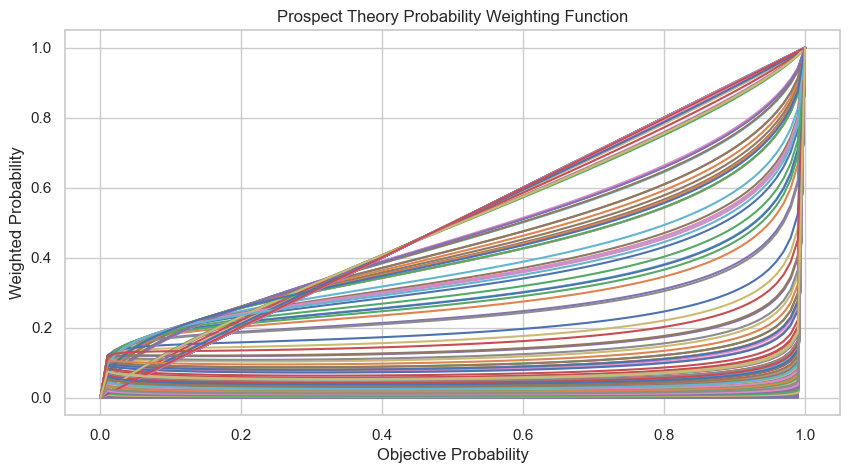

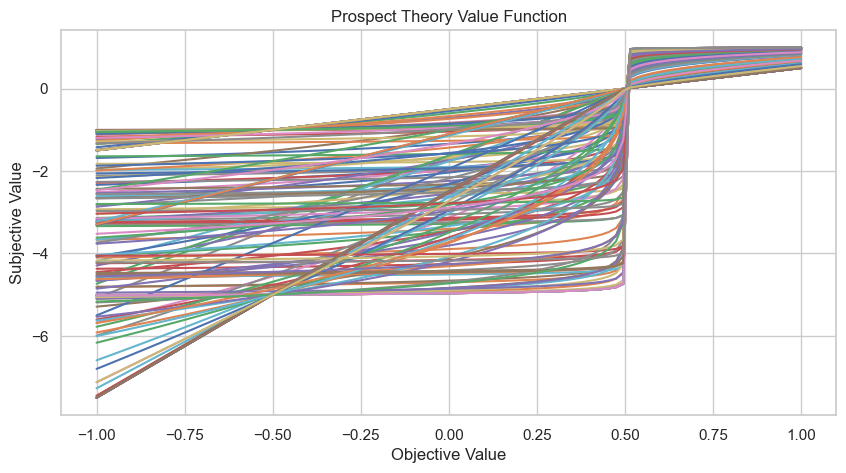

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_prospect_theory is already defined and contains the necessary data
# For demonstration, let's create a sample DataFrame similar to your data format
# df_prospect_theory = pd.DataFrame({
#     'alpha': np.random.rand(10),
#     'gamma': np.random.rand(10),
#     'lambda': np.random.rand(10) * 5,
#     'temp': np.random.rand(10) * 10,
#     'll': np.random.rand(10)
# })

# Define the value function and probability weighting function based on Prospect Theory
def value_function(r, alpha, lambda_, reference=0.5):
    delta = r - reference
    if delta >= 0:
        return delta ** alpha
    else:
        return -lambda_ * ((-delta) ** alpha)

def probability_weighting(p, gamma):
    numerator = p ** gamma
    denominator = (p ** gamma + (1 - p) ** gamma) ** (1 / gamma)
    return numerator / denominator

# Generate a range of probabilities and values
probabilities = np.linspace(0, 1, 100)
values = np.linspace(-1, 1, 100)

# Plot the probability weighting function for each set of parameters
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
for index, row in df_prospect_theory.iterrows():
    weighted_probabilities = [probability_weighting(p, row['gamma']) for p in probabilities]
    sns.lineplot(x=probabilities, y=weighted_probabilities, label=f'gamma={row["gamma"]:.2f}')
plt.xlabel('Objective Probability')
plt.ylabel('Weighted Probability')
plt.title('Prospect Theory Probability Weighting Function')
plt.legend().remove()
plt.show()

# Plot the value function for each set of parameters
plt.figure(figsize=(10, 5))
for index, row in df_prospect_theory.iterrows():
    valued_rewards = [value_function(v, row['alpha'], row['lambda']) for v in values]
    sns.lineplot(x=values, y=valued_rewards, label=f'alpha={row["alpha"]:.2f}, lambda={row["lambda"]:.2f}')
plt.xlabel('Objective Value')
plt.ylabel('Subjective Value')
plt.title('Prospect Theory Value Function')
plt.legend().remove()
plt.show()

In [146]:
# set group to df_prospect_theory

# set group to df_prospect_theory using the agent correspance in df
df_prospect_theory['group'] = df_prospect_theory['agent'].map(df.groupby('prolificID')['group'].first())


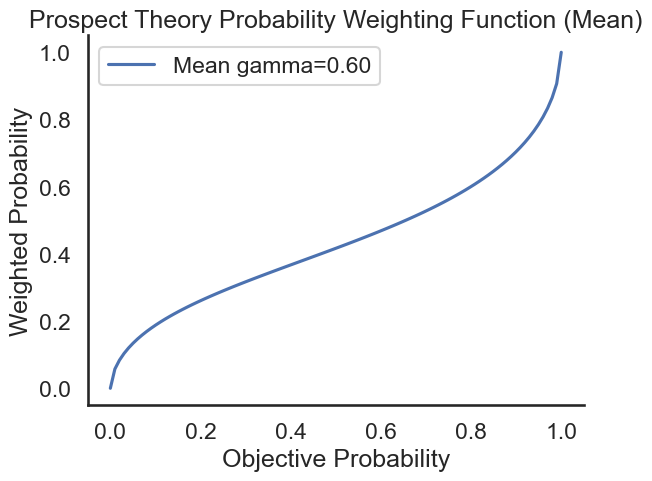

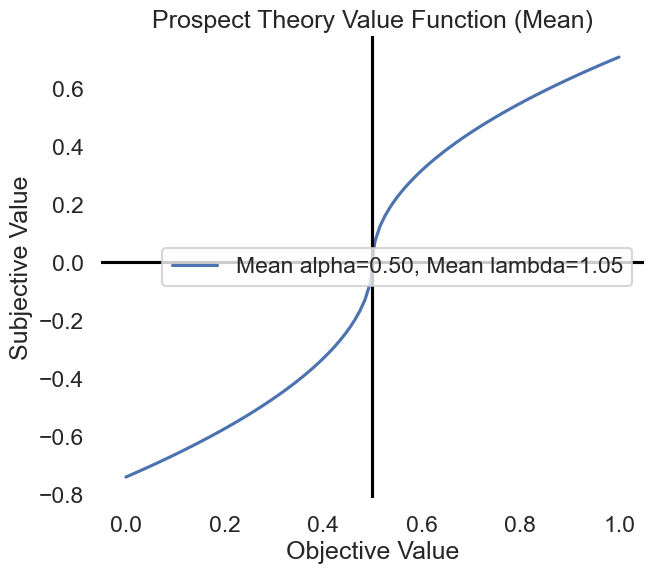

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_prospect_theory is already defined and contains the necessary data
# For demonstration, let's create a sample DataFrame similar to your data format
# df_prospect_theory = pd.DataFrame({
#     'alpha': np.random.rand(10),
#     'gamma': np.random.rand(10),
#     'lambda': np.random.rand(10) * 5,
#     'temp': np.random.rand(10) * 10,
#     'll': np.random.rand(10)
# })

# Define the value function and probability weighting function based on Prospect Theory
def value_function(r, alpha, lambda_, reference=0.5):
    delta = r - reference
    if delta >= 0:
        return delta ** alpha
    else:
        return -lambda_ * ((-delta) ** alpha)

def probability_weighting(p, gamma):
    numerator = p ** gamma
    denominator = (p ** gamma + (1 - p) ** gamma) ** (1 / gamma)
    return numerator / denominator

df_pros = df_prospect_theory[df_prospect_theory.group == 'value']
# Calculate the mean of the parameters across agents
mean_alpha = df_pros['alpha'].mean()
mean_gamma = df_pros['gamma'].mean()
mean_lambda = df_pros['lambda'].mean()

# Generate a range of probabilities and values
probabilities = np.linspace(0, 1, 100)
values = np.linspace(0, 1, 100)

# Apply the value function and probability weighting function using the mean parameters
weighted_probabilities = [probability_weighting(p, mean_gamma) for p in probabilities]
valued_rewards = [value_function(v, mean_alpha, mean_lambda) for v in values]

# Plot the mean probability weighting function
# sns.set(style="whitegrid")
sns.set_context('talk')
sns.set_style('white')

sns.lineplot(x=probabilities, y=weighted_probabilities, label=f'Mean gamma={mean_gamma:.2f}')
plt.xlabel('Objective Probability')
plt.ylabel('Weighted Probability')
plt.title('Prospect Theory Probability Weighting Function (Mean)')
plt.legend()
sns.despine()

# Plot the mean value function
plt.figure(figsize=(7, 6))
sns.lineplot(x=values, y=valued_rewards, label=f'Mean alpha={mean_alpha:.2f}, Mean lambda={mean_lambda:.2f}')
plt.xlabel('Objective Value')
plt.ylabel('Subjective Value')
plt.title('Prospect Theory Value Function (Mean)')
plt.legend()

# remove yaxis entirely and draw y axis at .5 and x axis at 0
plt.axhline(0., color='black')
plt.axvline(0.5, color='black')
# plt.ylim(0, 1)
# plt.xlim(-1, 1)
sns.despine(bottom=True, left=True, right=True, top=True)


In [48]:
from joblib import Parallel, delayed
import itertools
from pybads import BADS
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

# Assuming df and map_ff_values are predefined
exp = ['FullPilot12', 'FullPilot13', 'FullPilot14']
agents = df[df.expName.isin(exp)].agent.unique()
models = ['absolute']
parallel = True

# Function to optimize for one agent, model, and quarter
def optimize_agent_model_quarter(agent, model, quarter, agent_data):
    df2 = agent_data.copy()
    
    # Filter to only include session 3
    df2 = df2[df2.session == 3]
    
    # Drop rows where session==3 and pair is not in [0,1]
    condition = (~df2['pair'].isin([0, 1]))
    df2 = df2.loc[~condition]
    
    # Sort by trial number to ensure correct ordering
    df2 = df2.sort_values('t')
    
    # Calculate the total number of trials and quarter boundaries
    total_trials = df2.shape[0]
    quarter_size = total_trials // 4
    
    # Define quarter boundaries
    quarter_bounds = {
        0: (0, quarter_size),
        1: (quarter_size, 2*quarter_size),
        2: (2*quarter_size, 3*quarter_size),
        3: (3*quarter_size, total_trials)
    }
    
    # Get the start and end indices for this quarter
    start_idx, end_idx = quarter_bounds[quarter]
    
    # Slice the dataframe to include only trials in this quarter
    quarter_df = df2.iloc[start_idx:end_idx]
    
    # Extract required data
    s, a, r = quarter_df.s.values, quarter_df.a.values, quarter_df.r.values
    ff1, ff2 = quarter_df.ff1.values, quarter_df.ff2.values
    session = quarter_df.session.values
    destroy = quarter_df.destroy.values
    ntrials = quarter_df.shape[0]
    exp_name = quarter_df.expName.values[0]
    
    def target(x):
        return fit(x, *(exp_name, model, session, ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]
    
    # Set bounds based on model type
    if any(s in model for s in ['single', 'value', 'perceptual']):
        lower_bounds = np.array([0])
        upper_bounds = np.array([1e3])
        x0 = np.array([1])
    if any(s in model for s in ['absolute', 'log-ratio', 'absolute-var']):
        lower_bounds = np.array([0, 0])
        upper_bounds = np.array([1e3, 1e3])
        x0 = np.array([1, 1])
    
    # Run optimization
    bads = BADS(
        target,
        x0=x0,
        lower_bounds=lower_bounds,
        upper_bounds=upper_bounds,
        options={'display': 'off'}
    )
    optimize_result = bads.optimize()
    
    return {
        'agent': agent, 
        'model': model, 
        'quarter': quarter,
        'start_trial': start_idx,
        'end_trial': end_idx,
        'n_trials': ntrials,
        'x': optimize_result.x, 
        'll': optimize_result.fval
    }

# Prepare list of all agent-model-quarter combinations
quarters = [0, 1, 2, 3]  # 0-based indexing for quarters
tasks = list(itertools.product(agents, models, quarters))

if parallel:
    # Parallel execution with notebook-friendly progress bar
    results = []
    for result in Parallel(n_jobs=-2)(  # Use all available cores except 1
        delayed(optimize_agent_model_quarter)(
            agent, model, quarter, df[df.agent == agent].sort_values('t')
        ) for agent, model, quarter in tqdm(tasks)
    ):
        results.append(result)
else:
    # Non-parallel version
    results = []
    for agent, model, quarter in tqdm(tasks):
        results.append(optimize_agent_model_quarter(
            agent, model, quarter, df[df.agent == agent].sort_values('t')
        ))

# Gather results
df_fit_quarters = pd.DataFrame(results)

# Display example of results
print(f"Fitted {len(df_fit_quarters)} agent-model-quarter combinations")
df_fit_quarters.head()

  0%|          | 0/760 [00:00<?, ?it/s]

Fitted 760 agent-model-quarter combinations


,agent,model,quarter,start_trial,end_trial,n_trials,x,ll
0,610a1655e385fd7341e12778,absolute,0,0,36,36,"[516.8805389404297, 357.54713439941406]",21.277421
1,610a1655e385fd7341e12778,absolute,1,36,72,36,"[332.67709174752235, 5.21540641784668e-06]",20.176849
2,610a1655e385fd7341e12778,absolute,2,72,108,36,"[441.06415045261383, 106.6054156422615]",18.277421
3,610a1655e385fd7341e12778,absolute,3,108,144,36,"[1.0, 1.0]",24.244356
4,66f6c4195f17d26ce8c8018d,absolute,0,0,36,36,"[999.9993553161621, 107.77302551269531]",18.277421


In [59]:
from joblib import Parallel, delayed
import itertools
from pybads import BADS
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

# Assuming df and map_ff_values are predefined
exp = ['FullPilot12', 'FullPilot13', 'FullPilot14']
agents = df[df.expName.isin(exp)].agent.unique()
models = ['absolute']
parallel = True
n_divisions = 4  # Can be set to any number: 4 for quarters, 2 for halves, 10 for deciles, etc.

# Function to optimize for one agent, model, and division
def optimize_agent_model_division(agent, model, division_idx, agent_data, n_divisions):
    df2 = agent_data.copy()
    
    # Filter to only include session 3
    df2 = df2[df2.session == 3]
    
    # Drop rows where session==3 and pair is not in [0,1]
    condition = (~df2['pair'].isin([0, 1]))
    df2 = df2.loc[~condition]
    
    # Sort by trial number to ensure correct ordering
    df2 = df2.sort_values('t')
    
    # Calculate the total number of trials and division boundaries
    total_trials = df2.shape[0]
    division_size = total_trials / n_divisions  # Using floating point division for more accurate boundaries
    
    # Calculate the start and end indices for this division
    start_idx = int(division_size * division_idx)
    end_idx = int(division_size * (division_idx + 1)) if division_idx < n_divisions - 1 else total_trials
    
    # Slice the dataframe to include only trials in this division
    division_df = df2.iloc[start_idx:end_idx]
    
    # Extract required data
    s, a, r = division_df.s.values, division_df.a.values, division_df.r.values
    ff1, ff2 = division_df.ff1.values, division_df.ff2.values
    session = division_df.session.values
    destroy = division_df.destroy.values
    ntrials = division_df.shape[0]
    
    # Handle case where division might be empty
    if ntrials == 0:
        return {
            'agent': agent, 
            'model': model, 
            'division_idx': division_idx,
            'division_of': n_divisions,
            'start_trial': start_idx,
            'end_trial': end_idx,
            'n_trials': 0,
            'x': None, 
            'll': None
        }
    
    exp_name = division_df.expName.values[0]
    
    def target(x):
        return fit(x, *(exp_name, model, session, ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]
    
    # Set bounds based on model type
    if any(s in model for s in ['single', 'value', 'perceptual']):
        lower_bounds = np.array([0])
        upper_bounds = np.array([1e3])
        x0 = np.array([1])
    if any(s in model for s in ['absolute', 'log-ratio', 'absolute-var']):
        lower_bounds = np.array([0, 0])
        upper_bounds = np.array([1e3, 1e3])
        x0 = np.array([1, 1])
    
    # Run optimization
    try:
        bads = BADS(
            target,
            x0=x0,
            lower_bounds=lower_bounds,
            upper_bounds=upper_bounds,
            options={'display': 'off'}
        )
        optimize_result = bads.optimize()
        
        return {
            'agent': agent, 
            'model': model, 
            'division_idx': division_idx,
            'division_of': n_divisions,
            'start_trial': start_idx,
            'end_trial': end_idx,
            'n_trials': ntrials,
            'x': optimize_result.x, 
            'll': optimize_result.fval
        }
    except Exception as e:
        # Handle optimization failures
        return {
            'agent': agent, 
            'model': model, 
            'division_idx': division_idx,
            'division_of': n_divisions,
            'start_trial': start_idx,
            'end_trial': end_idx,
            'n_trials': ntrials,
            'x': None, 
            'll': None,
            'error': str(e)
        }

# Function to run optimization for multiple division schemes
def run_optimization(n_divisions_list=[4]):
    all_results = []
    
    for n_div in n_divisions_list:
        print(f"Running optimization with {n_div} divisions...")
        
        # Prepare list of all agent-model-division combinations
        divisions = list(range(n_div))  # 0-based indexing for divisions
        tasks = list(itertools.product(agents, models, divisions))
        
        if parallel:
            # Parallel execution with notebook-friendly progress bar
            division_results = []
            for result in Parallel(n_jobs=-2)(  # Use all available cores except 1
                delayed(optimize_agent_model_division)(
                    agent, model, div_idx, df[df.agent == agent].sort_values('t'), n_div
                ) for agent, model, div_idx in tqdm(tasks)
            ):
                division_results.append(result)
        else:
            # Non-parallel version
            division_results = []
            for agent, model, div_idx in tqdm(tasks):
                division_results.append(optimize_agent_model_division(
                    agent, model, div_idx, df[df.agent == agent].sort_values('t'), n_div
                ))
        
        all_results.extend(division_results)
    
    # Gather results
    df_fit_divisions = pd.DataFrame(all_results)
    return df_fit_divisions

# Run optimization with specified division schemes
# For example, to run with quarters, thirds, and halves:
df_fit_divisions = run_optimization(n_divisions_list=[10])


Running optimization with 10 divisions...


  0%|          | 0/1900 [00:00<?, ?it/s]

In [71]:
df_fit = df_fit_divisions.copy()

#get group of each agent
df_fit['group'] = df_fit['agent'].map(df.groupby('agent')['group'].first())


In [72]:
df_fit

,agent,model,division_idx,division_of,start_trial,end_trial,n_trials,x,ll,group
0,610a1655e385fd7341e12778,absolute,0,10,0,14,14,"[837.7021484375, 603.7958984375]",8.385664,perceptual
1,610a1655e385fd7341e12778,absolute,1,10,14,28,14,"[605.50146484375, 379.757568359375]",6.385664,perceptual
2,610a1655e385fd7341e12778,absolute,2,10,28,43,15,"[991.3628731369972, 534.262421131134]",8.698925,perceptual
3,610a1655e385fd7341e12778,absolute,3,10,43,57,14,"[926.6685954928398, 5.21540641784668e-06]",6.145435,perceptual
4,610a1655e385fd7341e12778,absolute,4,10,57,72,15,"[0.8834141232073307, 1.0337680578231812e-07]",10.314225,perceptual
...,...,...,...,...,...,...,...,...,...,...
1895,6745171138a79bddfee4e965,absolute,5,10,72,86,14,"[688.2778426110744, 5.21540641784668e-06]",4.765550,combined
1896,6745171138a79bddfee4e965,absolute,6,10,86,100,14,"[519.5814673544373, 1.0337680578231812e-07]",4.765549,combined
1897,6745171138a79bddfee4e965,absolute,7,10,100,115,15,"[805.2354736328125, 4.65478515625]",5.516119,combined
1898,6745171138a79bddfee4e965,absolute,8,10,115,129,14,"[837.7021484375, 104.7958984375]",5.385664,combined


In [73]:
# the x column should be split into two new columns beta_v and beta_p
df_fit[['beta_p', 'beta_v']] = pd.DataFrame(df_fit['x'].tolist(), index=df_fit.index)
df_fit = df_fit.drop(columns='x')

df_fit


,agent,model,division_idx,division_of,start_trial,end_trial,n_trials,ll,group,beta_p,beta_v
0,610a1655e385fd7341e12778,absolute,0,10,0,14,14,8.385664,perceptual,837.702148,6.037959e+02
1,610a1655e385fd7341e12778,absolute,1,10,14,28,14,6.385664,perceptual,605.501465,3.797576e+02
2,610a1655e385fd7341e12778,absolute,2,10,28,43,15,8.698925,perceptual,991.362873,5.342624e+02
3,610a1655e385fd7341e12778,absolute,3,10,43,57,14,6.145435,perceptual,926.668595,5.215406e-06
4,610a1655e385fd7341e12778,absolute,4,10,57,72,15,10.314225,perceptual,0.883414,1.033768e-07
...,...,...,...,...,...,...,...,...,...,...,...
1895,6745171138a79bddfee4e965,absolute,5,10,72,86,14,4.765550,combined,688.277843,5.215406e-06
1896,6745171138a79bddfee4e965,absolute,6,10,86,100,14,4.765549,combined,519.581467,1.033768e-07
1897,6745171138a79bddfee4e965,absolute,7,10,100,115,15,5.516119,combined,805.235474,4.654785e+00
1898,6745171138a79bddfee4e965,absolute,8,10,115,129,14,5.385664,combined,837.702148,1.047959e+02


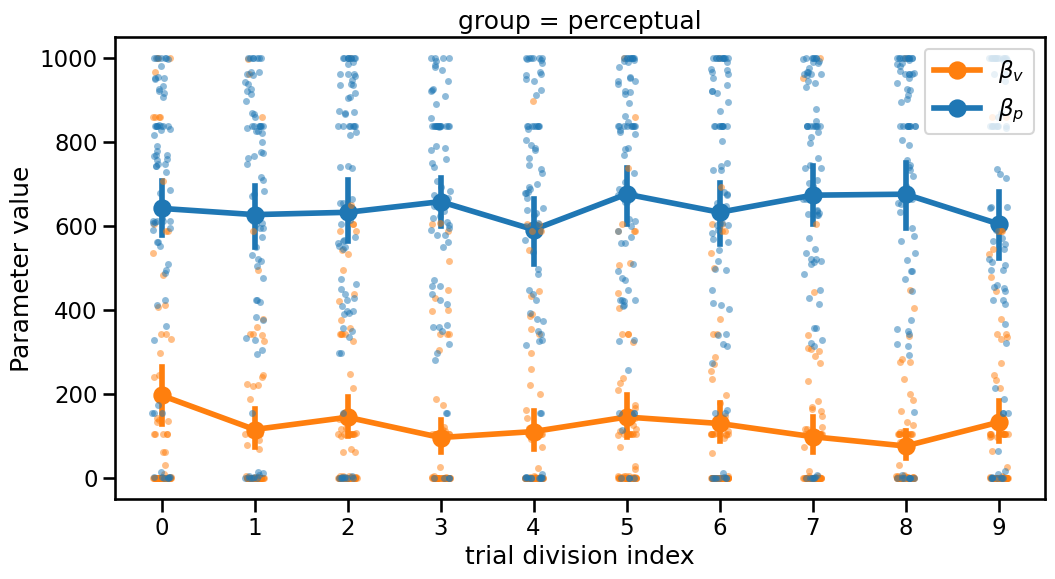

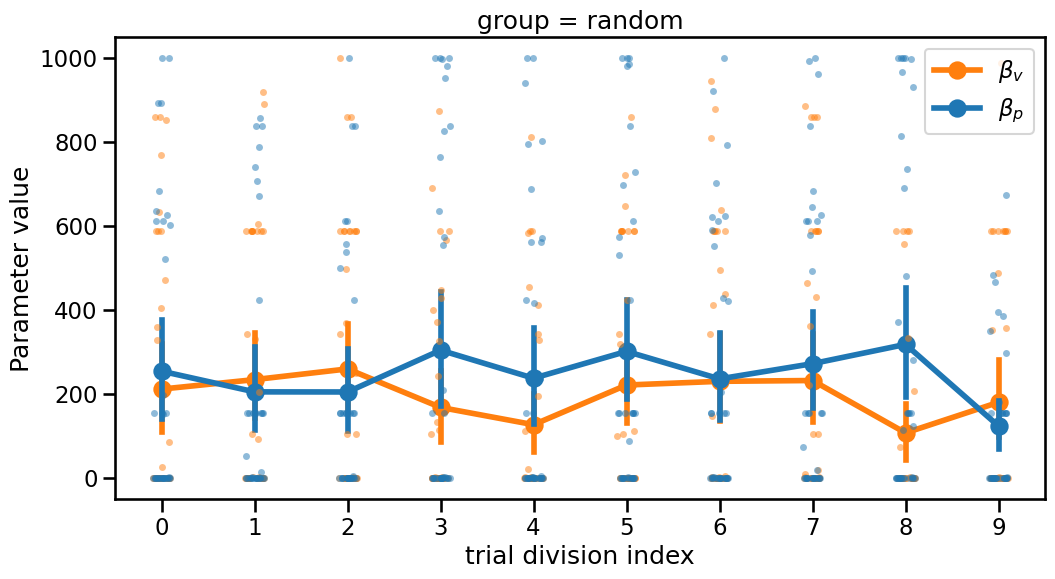

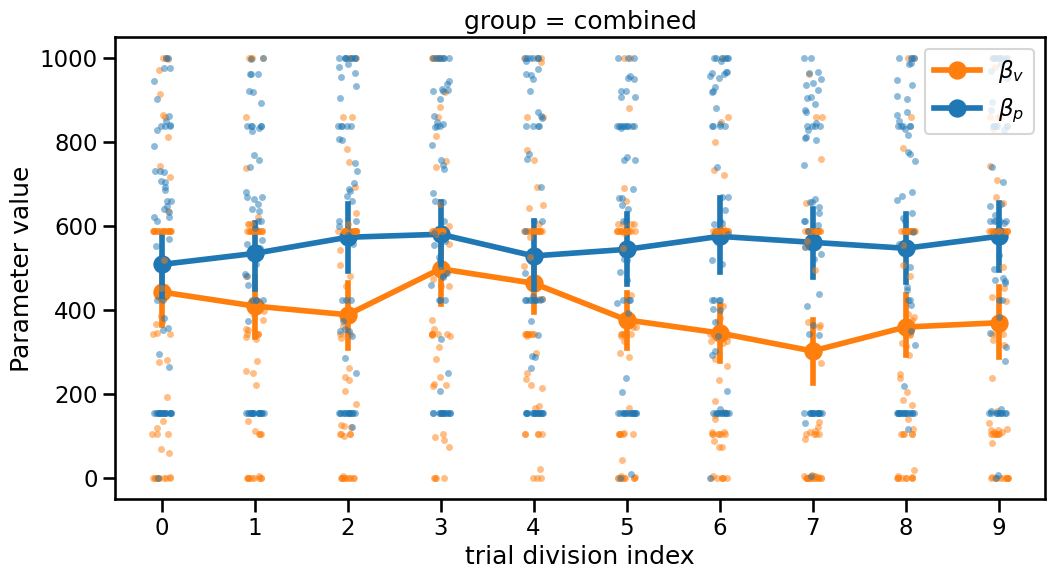

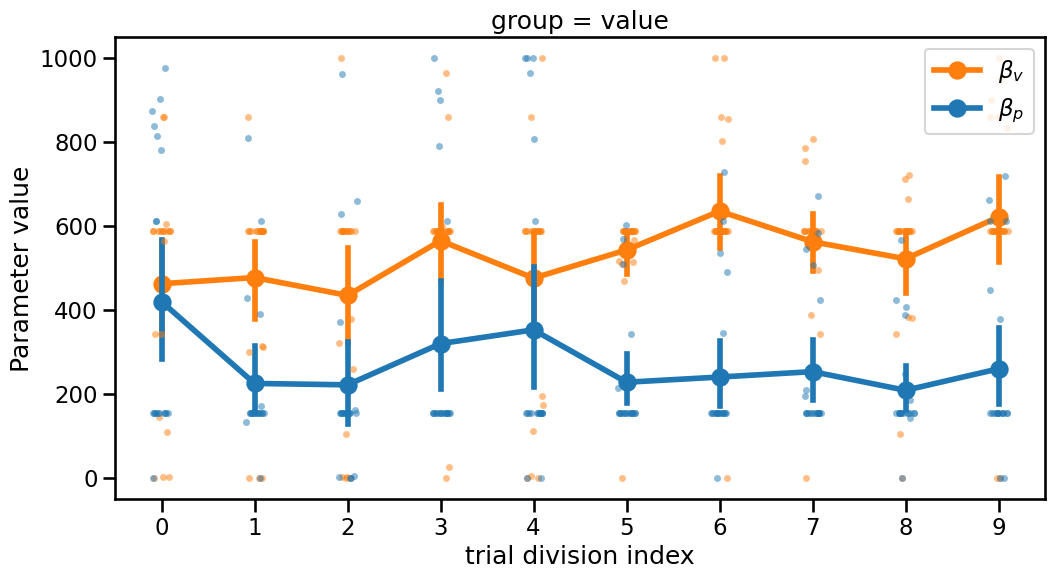

In [78]:
#now plot the evolution of the beta_v and beta_p over the quarters for each group
df_fit['division_idx'] = df_fit['division_idx']

# Plot the evolution of beta_v and beta_p over quarters for each group
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')

for group in df_fit['group'].unique():
    df_group = df_fit[df_fit['group'] == group]
    plt.figure(figsize=(12, 6))
    # sns.lineplot(data=df_group, x='division_idx', y='beta_v', label='$\\beta_v$', color='C1')
    # sns.lineplot(data=df_group, x='division_idx', y='beta_p', label='$\\beta_p$', color='C0')
    # now use boxplot with stripplot
    sns.pointplot(data=df_group, x='division_idx', y='beta_v', color='C1', label='$\\beta_v$')
    sns.stripplot(data=df_group, x='division_idx', y='beta_v', color='C1', alpha=0.5)
    sns.pointplot(data=df_group, x='division_idx', y='beta_p', color='C0', label='$\\beta_p$')
    sns.stripplot(data=df_group, x='division_idx', y='beta_p', color='C0', alpha=0.5)

    plt.title(f'group = {group}')
    plt.xlabel('trial division index')
    plt.ylabel('Parameter value')
    plt.legend(loc='upper right')
    plt.show()


In [76]:
from joblib import Parallel, delayed
import itertools
from pybads import BADS
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from scipy.special import logsumexp
from scipy.optimize import minimize

def fit_dynamic_sequential(agent, model, agent_data, map_ff_values):
    """
    Fits parameters sequentially, using data up to each trial to estimate parameters
    for the current trial. This provides a dynamic view of parameter evolution.
    
    Parameters:
    -----------
    agent : str
        Agent identifier
    model : str
        Model type ('single', 'absolute', 'value', 'perceptual', etc.)
    agent_data : DataFrame
        Data for this agent
    map_ff_values : dict
        Mapping of feature values
        
    Returns:
    --------
    DataFrame
        Trial-by-trial parameter estimates and log-likelihoods
    """
    print(f'Running dynamic fitting for agent {agent}, model {model}')
    df2 = agent_data.copy()
    
    # Drop rows where session==3 and pair is not in [0,1]
    condition = (df2['session'] == 3) & (~df2['pair'].isin([0, 1]))
    df2 = df2.loc[~condition]
    
    # Extract data
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    session = df2.session.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]
    exp = df2.expName.values[0]
    
    # Define bounds and initial parameters based on model type
    if any(submodel in model for submodel in ['single', 'value', 'perceptual']):
        x0 = np.array([1.0])
        lower_bounds = np.array([0.0])
        upper_bounds = np.array([1e3])
        param_bounds = [(0.0, 1e3)]
        param_count = 1
    elif any(submodel in model for submodel in ['absolute', 'log-ratio', 'absolute-var']):
        x0 = np.array([1.0, 1.0])
        lower_bounds = np.array([0.0, 0.0])
        upper_bounds = np.array([1e3, 1e3])
        param_bounds = [(0.0, 1e3), (0.0, 1e3)]
        param_count = 2
    
    # Arrays to store results
    trial_params = []
    trial_ll = []
    
    # Minimum number of trials needed for initial fitting
    min_trials = max(10, param_count * 5)  # Rule of thumb: at least 5 data points per parameter
    
    # For early trials, use default parameter values
    for t in range(min(min_trials, ntrials)):
        trial_params.append(x0.copy())
        trial_ll.append(None)  # No meaningful LL yet
    
    # Function to optimize for a subset of trials
    def target_for_subset(x, end_trial):
        return fit(x, *(exp, model, session[:end_trial], end_trial, s[:end_trial], a[:end_trial], r[:end_trial], 
                       destroy[:end_trial], ff1[:end_trial], ff2[:end_trial], map_ff_values.values()))[0]
    
    # For remaining trials, fit parameters using data up to that point
    for t in range(min_trials, ntrials, 5):
        if t % 10 == 0:
            print(f'  Processing trial {t}/{ntrials}')
            
        # Function to optimize for current subset of trials
        def current_target(x):
            return target_for_subset(x, t)
        
        # Optimize using previous trial's parameters as starting point
        try:
            # raise ValueError('stop')

            # Try BADS optimization first (better but may fail for some reason)
            bads = BADS(
                current_target,
                x0=trial_params[-1],
                lower_bounds=lower_bounds,
                upper_bounds=upper_bounds,
                options={'display': 'off', 'max_iter': 10000}
            )
            optimize_result = bads.optimize()
            new_params = optimize_result.x
        except Exception as e:
            print(f"BADS failed for trial {t}: {e}. Falling back to L-BFGS-B.")
            # Fall back to simpler optimizer if BADS fails
            result = minimize(current_target, trial_params[-1], bounds=param_bounds, 
                              method='L-BFGS-B', options={'maxiter': 50})
            new_params = result.x
        
        # Calculate log-likelihood for this trial with new parameters
        trial_params.append(new_params)
        
        # We need to simulate the model up to this point to get LL for this specific trial
        trial_ll_value, _ = fit(new_params, *(exp, model, session[:t+1], t+1, s[:t+1], a[:t+1], r[:t+1], 
                              destroy[:t+1], ff1[:t+1], ff2[:t+1], map_ff_values.values()))
        previous_ll, _ = fit(new_params, *(exp, model, session[:t], t, s[:t], a[:t], r[:t], 
                           destroy[:t], ff1[:t], ff2[:t], map_ff_values.values()))
        
        # LL for this specific trial is the difference between cumulative LL up to this point
        # and cumulative LL up to previous trial
        trial_ll.append(-(trial_ll_value - previous_ll))
    
    # Collect results into a DataFrame
    trial_data = []
    for t in range(ntrials):
        trial_dict = {
            'agent': agent,
            'model': model,
            'trial': t,
            'session': session[t],
            'll': trial_ll[t]
        }
        
        # Add parameter values
        if t < len(trial_params):
            for i, param_value in enumerate(trial_params[t]):
                trial_dict[f'param_{i}'] = param_value
            
        trial_data.append(trial_dict)
    
    return pd.DataFrame(trial_data)

def run_dynamic_model_fitting(df, agents, models, map_ff_values, parallel=False):
    """
    Run dynamic model fitting for multiple agents and models
    
    Parameters:
    -----------
    df : DataFrame
        Complete dataset
    agents : list
        List of agent IDs to process
    models : list
        List of model types to fit
    map_ff_values : dict
        Mapping of feature values
    parallel : bool
        Whether to use parallel processing
        
    Returns:
    --------
    DataFrame
        Combined trial-by-trial parameter estimates for all agent-model combinations
    """
    # Prepare list of all agent-model pairs
    tasks = list(itertools.product(agents, models))
    
    if parallel:
        # Parallel execution with progress bar
        results = []
        for result in Parallel(n_jobs=-2, backend='loky')(
            delayed(fit_dynamic_sequential)(agent, model, df[df.agent == agent].sort_values('t'), map_ff_values) 
            for agent, model in tqdm(tasks)
        ):
            results.append(result)
    else:
        # Sequential execution
        results = []
        for agent, model in tqdm(tasks):
            result = fit_dynamic_sequential(
                agent, model, df[df.agent == agent].sort_values('t'), map_ff_values
            )
            results.append(result)
    
    # Combine all results into one DataFrame
    return pd.concat(results, ignore_index=True)

# Example usage
# Assuming df and map_ff_values are defined elsewhere
exp = ['FullPilot12', 'FullPilot13', 'FullPilot14']
agents = df[df.expName.isin(exp)].agent.unique()[:1]  # First 5 agents
agents = df[df.prolificID=='5484d361fdf99b0379939d5b'].agent.unique()
# models = ['absolute', 'value', 'perceptual']
models = ['absolute']

# Run dynamic fitting
df_dynamic = run_dynamic_model_fitting(df, agents, models, map_ff_values, parallel=False)

# Save results
df_dynamic.to_csv('dynamic_model_fitting_results.csv', index=False)





  0%|          | 0/1 [00:00<?, ?it/s]

Running dynamic fitting for agent 5484d361fdf99b0379939d5b, model absolute
  Processing trial 10/287
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:InitialPointsOutsidePB. The starting points X0 are not inside the provided plausible bounds (plausible_lower_bounds and plausible_upper_bounds). Expanding the plausible bounds...
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
  Processing trial 20/287
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
  Processing trial 30/287
bads:InitialPointsTooClosePB: The starting points X0 are on or numerically too close to the hard bounds lower_bounds and upper_bounds. Moving the initial points more inside...
bads:TooCloseBounds: Fo

C:\Users\basil\AppData\Local\Temp\ipykernel_2524\1689451666.py:377: RuntimeWarning: overflow encountered in exp
  p1 = 1 / (1 + np.exp(-x))


  Processing trial 60/287
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
  Processing trial 70/287
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
  Processing trial 80/287
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
  Processing trial 90/287
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too 

IndexError: list index out of range

In [75]:
df_fit = pd.read_csv('../data/processed/fit_params.csv')

df_fit[df_fit.agent=='5484d361fdf99b0379939d5b'].round(2)
               

,agent,expName,group,model,value,ll,param,param2
408,5484d361fdf99b0379939d5b,FullPilot12,combined,absolute,745.21,133.63,$\beta_P$,beta_ff
409,5484d361fdf99b0379939d5b,FullPilot12,combined,absolute,455.05,133.63,$\beta_V$,beta_ss
410,5484d361fdf99b0379939d5b,FullPilot12,combined,value,406.77,148.51,$\beta$,beta
411,5484d361fdf99b0379939d5b,FullPilot12,combined,perceptual,811.94,172.28,$\beta$,beta


Text(0, 0.5, 'Parameter Value')

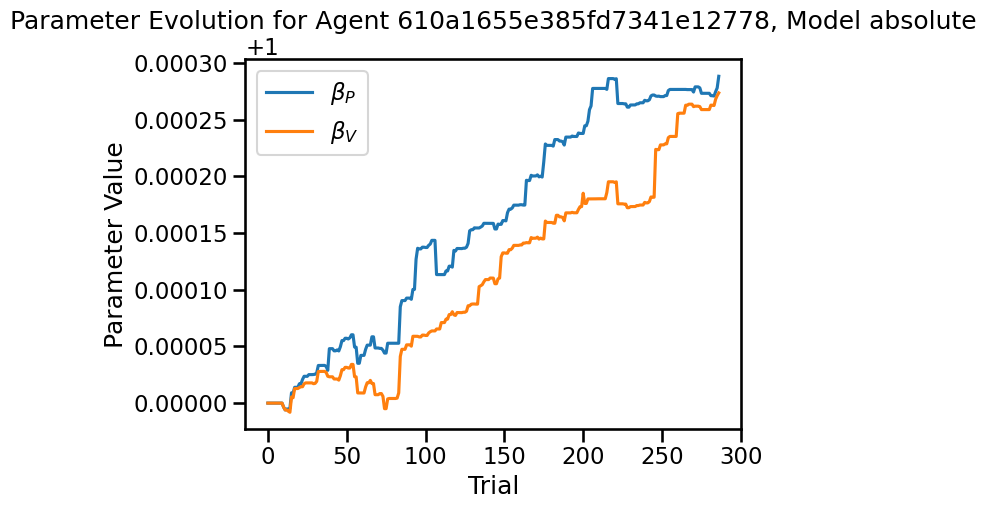

In [71]:


# rewrite the above using sns and context talk. param_1 is \beta_P and param_0 is \beta_V
import seaborn as sns
sns.set_context('talk')

data = df_dynamic.copy()
data['param_0'] = data['param_0'] 
data['param_1'] = data['param_1']

sns.lineplot(data=data, x='trial', y='param_0', label='$\\beta_P$')
sns.lineplot(data=data, x='trial', y='param_1', label='$\\beta_V$')

plt.title(f'Parameter Evolution for Agent {agent}, Model {model}')

plt.xlabel('Trial')
plt.ylabel('Parameter Value')
# plt.ylim(1, 1.0003)

In [45]:
df[(df.session==3) & (df.prolificID == '5484d361fdf99b0379939d5b')].opti_ss.mean()

0.7151162790697675

In [37]:
df[df.expName=='FullPilot12'].groupby(['group', 'prolificID']).opti_ss.mean().sort_values()

group       prolificID              
random      62b4ef82055cec7135502ada    0.361022
            64db80772c860983ea3a7310    0.361905
            628de7e8ff1744a9717d7883    0.363924
perceptual  60da2baf34bde948982f84db    0.368254
            6087ee3e8df094dc6dd69e8e    0.370253
                                          ...   
combined    66f09b3690fe3df51613a689    0.661392
            5484d361fdf99b0379939d5b    0.673016
            668180f26a3b162091510589    0.695238
            669ede47eb98d478aff45414    0.699367
value       66e74251d30f3f96be79e2f0    0.750000
Name: opti_ss, Length: 61, dtype: float64

In [14]:
# get tmax for session 3
tmax = df[df.session==2].groupby('prolificID').t.max().reset_index()
tmax

,prolificID,t
0,5484a2b2fdf99b07b28f2335,143
1,5484d361fdf99b0379939d5b,143
2,559c3a4dfdf99b32b6963e70,143
3,57027c1f68c641000e0c8970,143
4,57bb618b8e26d6000196c3bb,143
...,...,...
185,675efe6044b2f5bde425ceac,143
186,67603ec6f369599a362eecb9,143
187,67628f7b4f57e91918c49e72,143
188,677a58735c4ac72aaffc95a7,143


In [15]:
df_fit.x.values[0][0]

737.6708601415157

In [10]:
pd.DataFrame(xopt)

610a1655e385fd7341e12778                      \
                                       absolute               value   
x   [266.9465043840524, 1.5234036254696548e-11]  [0.42132568359375]   
ll                                   187.275708          198.660743   

                                       66f6c4195f17d26ce8c8018d  \
             perceptual                                absolute   
x   [878.1636657714844]  [750.6124954904133, 46.11057326778564]   
ll           187.017074                              158.671792   

                                                \
                   value            perceptual   
x   [1.6355094568098139]  [23.471522971987724]   
ll            196.278654            166.937859   

                           636590165e6fcc3e84ee2b6d                 \
                                           absolute          value   
x   [1.0231815394945443e-12, 0.0043040901164204115]  [0.025390625]   
ll                                       194.081576     194.082724   

                                            660d619f39d061875f78ac8c  ...  \
                perceptual                                  absolute  ...   
x   [5.21540641784668e-06]  [0.0025482177734375, 0.0025482177734375]  ...   
ll               194.08123                                205.194302  ...   

   6751e21bab5bb259997e4c67                  67628f7b4f57e91918c49e72  \
                 perceptual                                  absolute   
x       [584.9837391413748]  [792.6944855517481, 0.02517771808879843]   
ll               139.890525                                160.012979   

                                                  \
                      value           perceptual   
x   [4.982948303222656e-05]  [755.9198454558064]   
ll               192.694934           160.488035   

              67055efcc9d6595c24d60bb5                                        \
                              absolute            value           perceptual   
x   [869.1637573242188, 573.095703125]  [189.099609375]  [557.8934119045734]   
ll                          149.459851       173.344436           177.671167   

                  6745171138a79bddfee4e965                        \
                                  absolute                 value   
x   [840.2721062012779, 83.49880968081288]  [502.83532328946967]   
ll                              133.977037            184.989603   

                      
          perceptual  
x   [145.7294921875]  
ll        154.788478  

[2 rows x 570 columns]

In [ ]:
# save the dict xopt
import pickle
with open('xopt_absolute_var_4.pkl', 'wb') as f:
    pickle.dump(xopt, f)

In [1]:
import pickle 
xopt = pickle.load(open('xopt_absolute_var_12_abs_abs_var_not_norm_before+z_by_obj_val.pkl', 'rb'))

In [16]:
# make a dataframe with the fitted values that are arrays of length 2 in a dic then convert to a dataframe
d = []
for (agent, model), value in xopt.items():
    if agent not in df.prolificID.values:
        continue
    # print(agent, model, value['x'], value['ll'])

    if any(s in model for s in ['single', 'value', 'perceptual']):
        d.append({
            'agent': agent,
            'expName': df[df.prolificID==agent].expName.values[0],
            'group': df[df.prolificID==agent].group.values[0],
            'model': model,
            'value': value['x'][0],
            'll': value['ll'],
            'param': '$\\beta$',
            'param2': 'beta'
        })
        
    else:
       
        d.append({
            'agent': agent,
            'expName': df[df.prolificID==agent].expName.values[0],
            'group': df[df.prolificID==agent].group.values[0],
            'model': model,
            'value': value['x'][0],
            'll': value['ll'],
            'param': '$\\beta_P$',
            'param2': 'beta_ff'
        })
        
        d.append({
            'agent': agent,
            'expName': df[df.prolificID==agent].expName.values[0],
            'group': df[df.prolificID==agent].group.values[0],
            # 'model': 'NormativeEV',
            'model': model,
            'value': value['x'][1],
            'll': value['ll'],
            'param': '$\\beta_V$',
            'param2': 'beta_ss'
        })

        # dd.append({
        #         'agent': agent,
        #         'expName': df[df.prolificID==agent].expName.values[0],
        # 'group': df[df.prolificID==agent].group.values[0],
        # 'model': model,
        # 'value': value['x'][2],
        # 'll': value['ll'],
        # 'param': '$\\lambda$',
        #     'param2': 'leak'
        # })

dd = pd.DataFrame(d)
# dd.to_csv('../data/processed/fit_params_fullpilot13_2_models.csv', index=False)

In [297]:
dd = pd.concat([dd, pd.DataFrame(dd2)])

In [19]:
dd.groupby(['model']).size()

model
absolute      380
perceptual    190
value         190
dtype: int64

In [4]:
import pandas as pd
dd = pd.read_csv('../data/processed/fit_params.csv') 

In [5]:

n_param = {
    'single': 1,
    'value': 1,
    'perceptual': 1,
    'value-var': 1,
    'perceptual-var': 1,
    'absolute': 2,
    'log-ratio': 2,
    'absolute-var': 2,
    'random': 0
}

def compute_bic(ddf):
    size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size().values[0]
    return 2 * ddf.ll + ddf.n_param * np.log(size)

In [19]:
dd.to_csv('../data/processed/fit_params_absolute_var_7_session_3_only.csv', index=False)

## P(MODEL)

## model x group

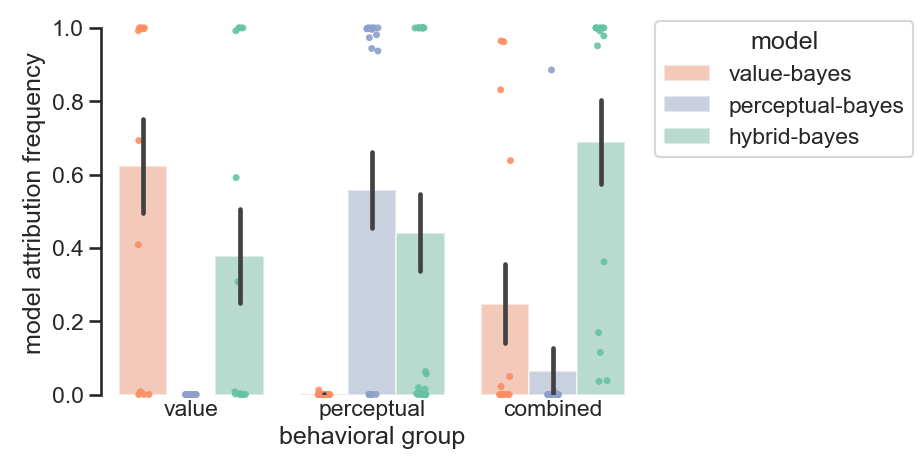

In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    # remove param2 == 'beta_ss' because it is doubled for log-ratio
    # and absolute
    # df = df[df.param2!='beta_ss']
    dic = {}
    for i in x:
        final_array = []
        for j in hue:
            # print(i, j)
            array = df[(df.group==i) & (df.model==j)].BIC.values
            final_array.append(array)
        dic[i] = np.array(final_array)

    return dic

by_pid = dd[dd.expName=='FullPilot13'].groupby(['agent', 'model','group']).ll.first().reset_index()
by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

from groupBMC.groupBMC import GroupBMC

x = ['value', 'perceptual', 'combined']
hues = ['value', 'perceptual', 'absolute']
L = create_array(x=x,
                  hue=hues, df=by_pid)

for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.group==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]


sns.set({'figure.figsize': (7, 5), 'figure.dpi': 100})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = ['value', 'perceptual', 'combined']
palette = ['C1', 'C2', 'C0']
# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=order,
            hue_order=hues, palette=palette)


x_values = by_pid['group'].unique()
hue_values = by_pid['model'].unique()
pairs = generate_combinations(x_values, hue_values)

# annotator = Annotator(ax, pairs, data=by_pid, x='group', y='P(model)', order=order, hue='model', hue_order=hues, loc='inside')
# annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
# annotator.apply_and_annotate()

sns.stripplot(data=by_pid, x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=order,
            hue_order=hues, palette=palette, clip_on=False)
# plt.ylim(200, 600)
plt.ylabel('model attribution frequency')
plt.xlabel('behavioral group')
# plt.title(new_exp[exp])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), handles=handles[:3], labels=['value-bayes', 'perceptual-bayes', 'hybrid-bayes'], title='model', loc='upper left')

sns.despine(bottom=True, trim=True)
# xtick length =0 
plt.tick_params(axis='x', length=0)


## Exp x group x model

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:69: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute vs. combined_absolute-var: t-test paired samples, P_val:2.804e-10 t=-1.375e+01
random_absolute vs. random_absolute-var: t-test paired samples, P_val:4.420e-01 t=-8.043e-01
random_value vs. random_perceptual: t-test paired samples, P_val:9.362e-02 t=1.875e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:1.363e-14 t=-1.456e+01
combined_value vs. combined_perceptual: t-test paired samples, P_val:2.230e-01 t=1.268e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:3.732e-01 t=-1.002e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:1.752e-01 t=-1.645e+00
value_value vs. value_perceptual: t-test paired samples, P_val:6.728e-02 t=2.493e+00
perceptual_perceptual vs. perceptual_absolute: t-test paired samples, P_va

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:81: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:69: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute vs. combined_absolute-var: t-test paired samples, P_val:4.662e-05 t=-5.971e+00
random_absolute vs. random_absolute-var: t-test paired samples, P_val:1.554e-01 t=-1.508e+00
random_value vs. random_perceptual: t-test paired samples, P_val:1.820e-02 t=2.700e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:3.703e-24 t=-5.003e+01
combined_value vs. combined_perceptual: t-test paired samples, P_val:3.204e-02 t=2.401e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:2.336e-01 t=-1.254e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:3.386e-02 t=-2.394e+00
value_value vs. value_perceptual: t-test paired samples, P_val:1.852e-04 t=5.310e+00
perceptual_perceptual vs. perceptual_absolute: t-test paired samples, P_va

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:81: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:69: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],


random_absolute vs. random_absolute-var: t-test paired samples, P_val:3.119e-02 t=-2.505e+00
random_value vs. random_perceptual: t-test paired samples, P_val:5.562e-01 t=6.088e-01
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:1.550e-32 t=-1.070e+02
combined_value vs. combined_perceptual: t-test paired samples, P_val:6.311e-02 t=-1.941e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:3.548e-01 t=-1.194e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:3.784e-01 t=-1.122e+00
value_value vs. value_perceptual: t-test paired samples, P_val:1.483e-01 t=2.299e+00
perceptual_perceptual vs. perceptual_absolute: t-test paired samples, P_val:1.501e-01 t=1.489e+00
perceptual_value vs. perceptual_perceptual: t-test paired samples, P_val:1.469e-01 t=-1.501e+00
combined_perceptual vs. combined_absolute: t-test paired samples, P_val:6.136e-02 t=1.955e+00
random_perceptual vs. random_absolute: t-test paired samples, P_val:7.566e

C:\Users\garciaba\AppData\Local\Temp\ipykernel_7536\2397517227.py:81: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],


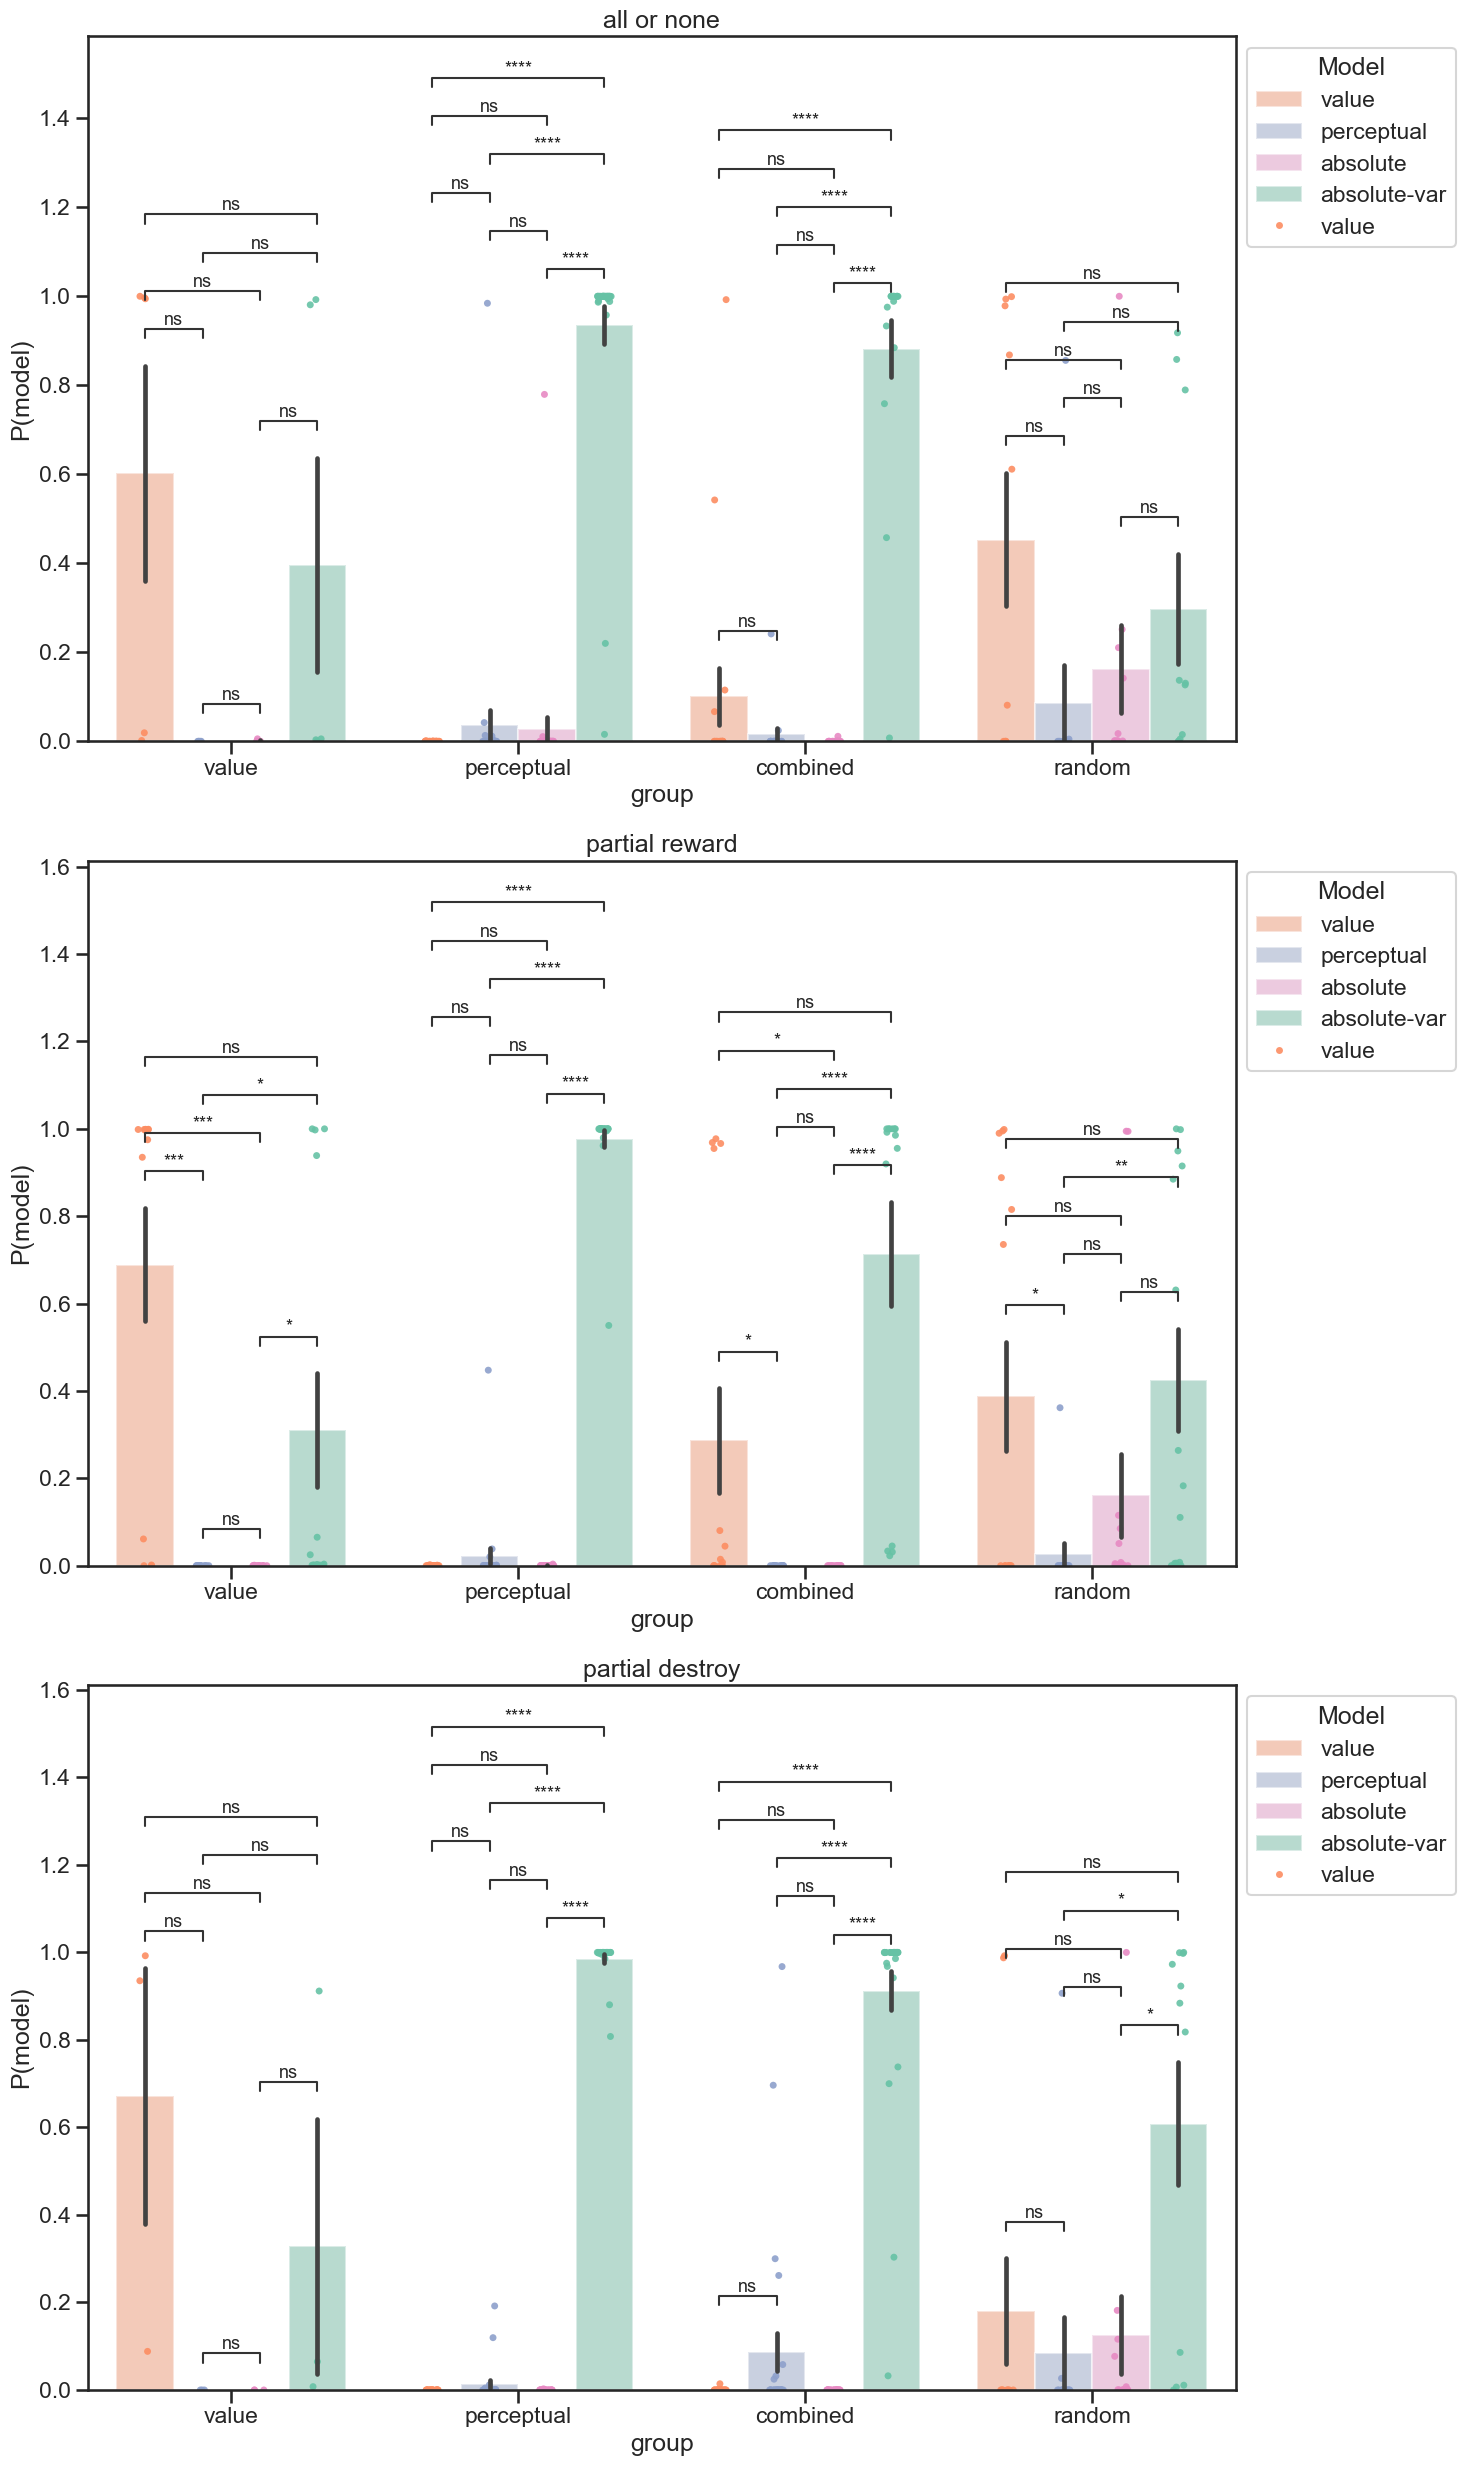

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    # remove param2 == 'beta_ss' because it is doubled for log-ratio
    # and absolute
    # df = df[df.param2!='beta_ss']
    dic = {}
    for i in x:
        final_array = []
        for j in hue:
            # print(i, j)
            array = df[(df.group==i) & (df.model==j)].BIC.values
            final_array.append(array)
        dic[i] = np.array(final_array)

    return dic

by_pid = dd.groupby(['agent', 'expName', 'model','group']).ll.first().reset_index()
by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

from groupBMC.groupBMC import GroupBMC

x = ['value', 'perceptual', 'combined', 'random']
hues = ['value', 'perceptual', 'absolute', 'absolute-var']
L = create_array(x=x,
                  hue=hues, df=by_pid)

for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.group==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]


sns.set({'figure.figsize': (15, 25)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')

new_exp ={
    'FullPilot12': 'all or none',
    'FullPilot13': 'partial reward',
    'FullPilot14': 'partial destroy'
}
count = 0
for exp in ['FullPilot12', 'FullPilot13', 'FullPilot14']:
    count+=1
    order = ['value', 'perceptual', 'combined', 'random']
    plt.subplot(3, 1, count)

    # Filter data for a specific experiment (e.g., 'FullPilot13') and plot
    # plt.subplot(1, 2, 1)
    ax = sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],
                hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])


    x_values = by_pid['group'].unique()
    hue_values = by_pid['model'].unique()
    pairs = generate_combinations(x_values, hue_values)

    annotator = Annotator(ax, pairs, data=by_pid[by_pid.expName==exp], x='group', y='P(model)', order=order, hue='model', hue_order=hues, loc='inside')
    annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
    annotator.apply_and_annotate()

    sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
                hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
    # plt.ylim(200, 600)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')
    

    plt.title(new_exp[exp])
plt.tight_layout()





## model x exp.

C:\Users\garciaba\AppData\Local\Temp\ipykernel_13120\136590450.py:74: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.barplot(data=by_pid, x='expName', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=order,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

FullPilot13_perceptual vs. FullPilot13_absolute: t-test paired samples, P_val:4.261e-01 t=-8.011e-01
FullPilot13_value vs. FullPilot13_perceptual: t-test paired samples, P_val:9.686e-01 t=3.957e-02
FullPilot14_perceptual vs. FullPilot14_absolute: t-test paired samples, P_val:7.097e-01 t=3.739e-01
FullPilot14_value vs. FullPilot14_perceptual: t-test paired samples, P_val:7.049e-08 t=-6.092e+00
FullPilot12_perceptual vs. FullPilot12_absolute: t-test paired samples, P_val:9.976e-03 t=-2.661e+00
FullPilot12_value vs. FullPilot12_perceptual: t-test paired samples, P_val:6.704e-01 t=-4.276e-01
FullPilot13_value vs. FullPilot13_absolute: t-test paired samples, P_val:4.361e-01 t=-7.838e-01
FullPilot14_value vs. FullPilot14_absolute: t-test paired samples, P_val:1.819e-06 t=-5.254e+00
FullPilot12_value vs.

C:\Users\garciaba\AppData\Local\Temp\ipykernel_13120\136590450.py:86: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.stripplot(data=by_pid, x='expName', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=order,


([<matplotlib.axis.XTick at 0x2d6521f0af0>,
 [Text(0, 0, 'all or none'),
  Text(1, 0, 'partial reward'),
  Text(2, 0, 'partial destroy')])

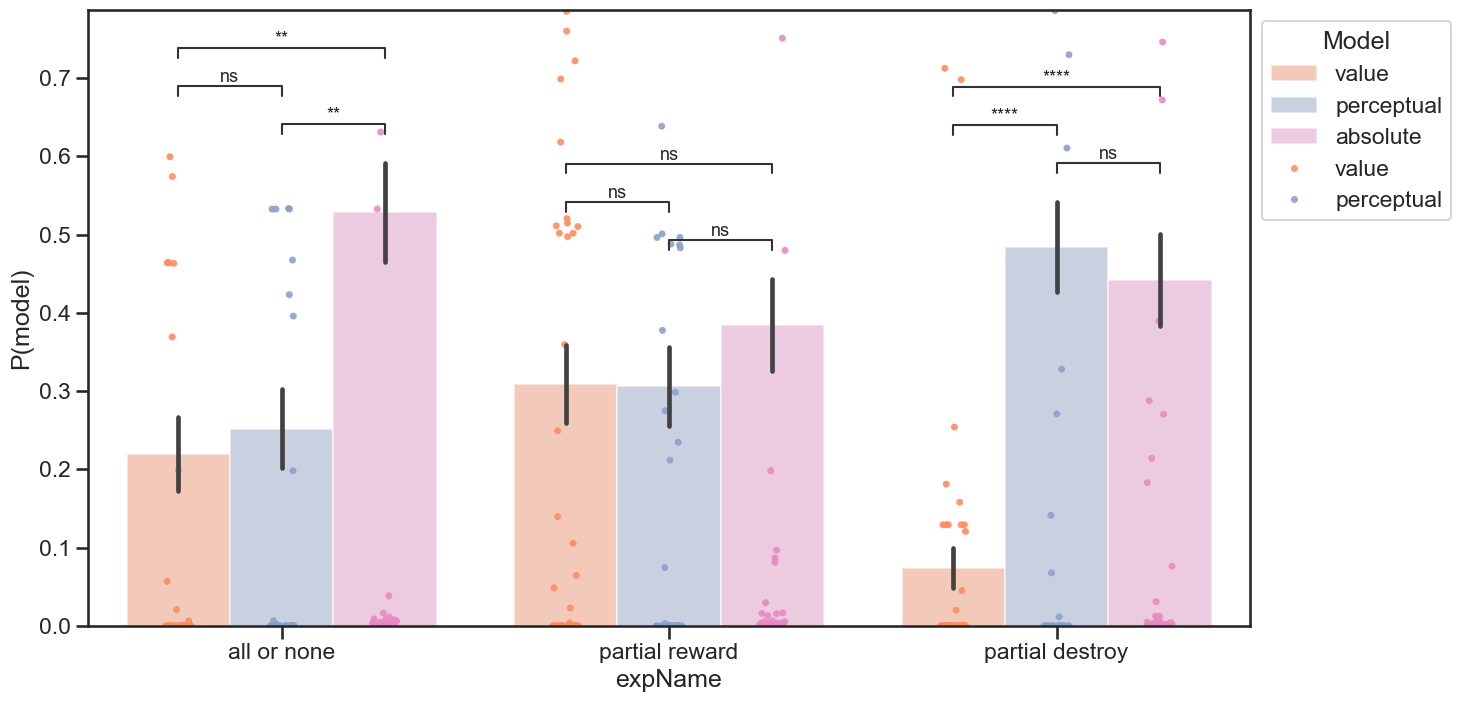

In [19]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    # remove param2 == 'beta_ss' because it is doubled for log-ratio
    # and absolute
    if df.get('param2') is not None:
        df = df[df.param2!='beta_ss']
    dic = {}
    for i in x:
        final_array = []
        for j in hue:
            # print(i, j)
            array = df[(df.expName==i) & (df.model==j)].BIC.values
            final_array.append(array)
        dic[i] = np.array(final_array)

    return dic




# Assuming 'df' and 'dd' are your original DataFrame and Dask DataFrame
# Filter the session data
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first
by_pid = dd.groupby(['expName', 'agent', 'model']).ll.first().reset_index()
by_pid['n_param'] = by_pid['model'].map(n_param)
# by_pid['model'] = by_pid['model'].map({'single': '$1 \\beta$', 'log-ratio': '$2 \\beta$'})
# by_pid['model'] = by_pid['model'].map({'independent': 'absolute', 'single': 'single', 'log-ratio': 'log-ratio'})
# Ensure that 'll' contains negative log likelihood and compute BIC
bic = compute_bic(by_pid)

# Add BIC to the DataFrame
by_pid['BIC'] = bic

from groupBMC.groupBMC import GroupBMC

x = ['FullPilot12', 'FullPilot13', 'FullPilot14']   
hues = ['value', 'perceptual', 'absolute']
L = create_array(x=x,
                  hue=hues, df=by_pid)


for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.expName==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]


sns.set({'figure.figsize': (15, 8)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = x

# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, x='expName', y='P(model)', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=order,
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])


x_values = by_pid['expName'].unique()
hue_values = by_pid['model'].unique()
pairs = generate_combinations(x_values, hue_values)

annotator = Annotator(ax, pairs, data=by_pid, x='expName', y='P(model)', order=order, hue='model', hue_order=hues, loc='inside')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
annotator.apply_and_annotate()

sns.stripplot(data=by_pid, x='expName', y='P(model)', hue='model', dodge=True, alpha=0.9, zorder=1,order=order,
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
# plt.ylim(200, 600)

# plt.title(new_exp[exp])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')
plt.xticks([0, 1, 2], ['all or none', 'partial reward', 'partial destroy'])



#  delta stripplot with colors from group

Text(0, 0.5, '$\\beta_{P} - \\beta_{V}$')

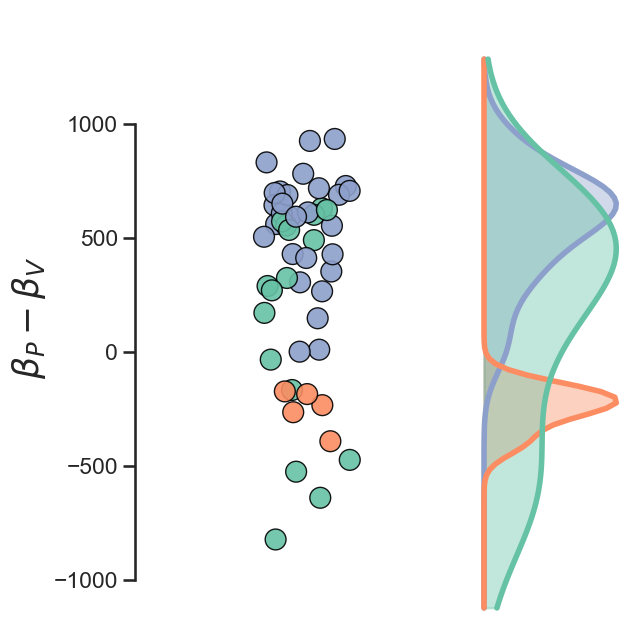

In [131]:
# melt dd into a df with expName, agent, model, group, beta_ff, beta_ss columns

beta_ss = dd[dd.param2=='beta_ss']
beta_ff = dd[dd.param2=='beta_ff']
agent = beta_ss.agent.values
expName = beta_ss.expName.values
group = beta_ss.group.values
model = beta_ss.model.values

dd2 = pd.DataFrame({
    'agent': agent,
    'expName': expName,
    'group': group,
    'model': model,
    'beta_ff': beta_ff.value.values,
    'beta_ss': beta_ss.value.values,
    'll': beta_ss.ll.values,
    'delta': beta_ff.value.values - beta_ss.value.values
})

dd2 = dd2[(dd2.group!='random') & (dd2.expName=='FullPilot12') & (dd2.group.isin(['value', 'perceptual', 'combined']))]

palette = sns.color_palette('Set2')
palette = [palette[2], palette[1], palette[0]]
sns.set({'figure.figsize': (5, 8), 'figure.dpi': 100})
sns.set_style('ticks')
sns.set_context('talk')

# Create a figure with enough width

# Set positions for dots and KDE to be closer together
dot_position = 1
kde_start = 0.4

# Draw the stripplot on the left
sns.stripplot(data=dd2, x=np.ones(len(dd2))*dot_position, y='delta', hue='group', 
              hue_order=['perceptual', 'value', 'combined'], 
              palette=palette, edgecolor='black', size=15, linewidth=1, alpha=0.9)

plt.ylim(-1100, 1100)

# Draw vertical KDE on the right with peaks facing right
for i, group_name in enumerate(['perceptual', 'value', 'combined']):
    subset = dd2[dd2.group == group_name]
    # Use gaussian_kde for more control over the orientation
    kde = stats.gaussian_kde(subset['delta'].values)
    x_pts = np.linspace(dd2.delta.min()-300, dd2.delta.max()+350, 100)
    density = kde(x_pts)
    # Scale density for visibility
    max_density = density.max()
    scaled_density = density / max_density * 0.3  # Scale to make it visible but not too wide
    # Plot the KDE curve horizontally
    plt.fill_betweenx(x_pts, kde_start, kde_start + scaled_density, color=palette[i], alpha=0.4)
    plt.plot(kde_start + scaled_density, x_pts, color=palette[i], lw=4)

# plt.ylim(min(x_pts) - 100, max(x_pts) + 100)  # Add padding to y-limits to show full distribution
# Set x-axis limits to fit the visualization with less empty space
# plt.xlim(0.5, kde_start + 1.0)
plt.xticks([], [])
plt.ylim(-1200, 1500)
# now cut the y-axis at 1000
plt.yticks(np.arange(-1000, 1500, 500), fontsize=20)
# Add a legend only once
handles, labels = plt.gca().get_legend_handles_labels()
# legend outside the plot
plt.legend(handles[:3], labels[:3], title='behavioral group', bbox_to_anchor=(1, 1), loc='upper left')
plt.legend().remove()
sns.despine(trim=True, bottom=True, offset=80)
plt.xlabel('')
plt.ylabel('$\\beta_{P} - \\beta_{V}$', fontdict={'fontsize': 25})

In [66]:
# nsub
dd2.groupby('agent').size().value_counts()

1    155
Name: count, dtype: int64

C:\Users\basil\AppData\Local\Temp\ipykernel_38540\554644498.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\554644498.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\554644498.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)


IndexError: cannot do a non-empty take from an empty axes.

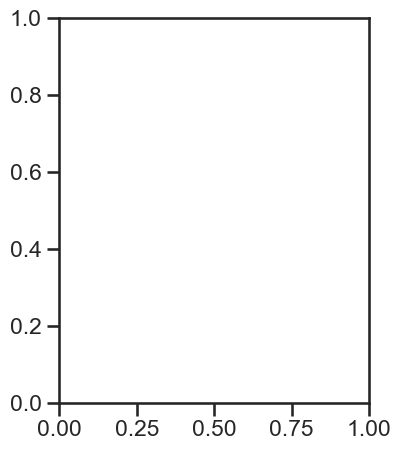

In [32]:
# melt dd into a df with expName, agent, model, group, beta_ff, beta_ss columns

beta_ss = dd[dd.param2=='beta_ss']
beta_ff = dd[dd.param2=='beta_ff']
agent = beta_ss.agent.values
expName = beta_ss.expName.values
group = beta_ss.group.values
model = beta_ss.model.values

dd2 = pd.DataFrame({
    'agent': agent,
    'expName': expName,
    'group': group,
    'model': model,
    'beta_ff': beta_ff.value.values,
    'beta_ss': beta_ss.value.values,
    'll': beta_ss.ll.values,
    'delta': beta_ff.value.values - beta_ss.value.values
})

palette = sns.color_palette('Set2')
palette = [palette[2], palette[1], palette[0]]
sns.set_style('ticks')
sns.set_context('talk')

# i want also a kde region highlight (zone) of the delta values
sns.kdeplot(data=dd2, x=0, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, fill=True)
sns.stripplot(data=dd2, x=1, y='delta', hue='group', hue_order=['perceptual', 'value', 'combined'], palette=palette, edgecolor='black', size=10)

## Pooled


[('value', 'perceptual'), ('value', 'absolute'), ('perceptual', 'absolute')]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

value vs. perceptual: t-test paired samples, P_val:7.316e-04 t=-3.434e+00
perceptual vs. absolute: t-test paired samples, P_val:9.232e-02 t=-1.692e+00
value vs. absolute: t-test paired samples, P_val:1.862e-06 t=-4.922e+00


C:\Users\basil\AppData\Local\Temp\ipykernel_38540\4056480850.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=by_pid, x='model', y='P(model)', errorbar='se', alpha=0.5, zorder=-1, order=order,
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\4056480850.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=by_pid, x='model', y='P(model)', alpha=0.9, zorder=1,order=order, size=5, clip_on=False,


(0.0, 1.0)

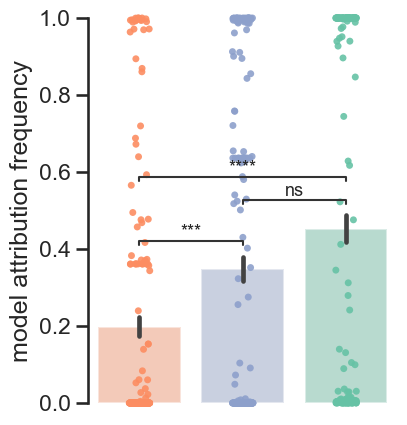

In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in itertools.combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result


# Group by the necessary columns and compute first
by_pid = dd.groupby(['agent', 'model']).ll.first().reset_index()
by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

from groupBMC.groupBMC import GroupBMC

models = ['value', 'perceptual', 'absolute']

L = []
for m in models:
  L.append(-by_pid[by_pid.model==m].BIC.values)

L = np.array(L)
results = GroupBMC(L).get_result()

for i, m in enumerate(models):
    by_pid.loc[(by_pid.model==m), 'P(model)'] = results.attribution[i]


sns.set({'figure.figsize': (4, 5)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = models
palette = ['C1', 'C2', 'C0']
# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, x='model', y='P(model)', errorbar='se', alpha=0.5, zorder=-1, order=order,
 palette=palette)


pairs = list(itertools.combinations(models, 2))
# pairs = [('absolute', 'absolute-var'),
#           ('absolute', 'random'), ('absolute-var', 'random'),
#             ('value', 'perceptual'), ('value', 'absolute'),
#               ('value', 'absolute-var'), ('value', 'random'),
#                 ('perceptual', 'absolute'), ('perceptual', 'absolute-var'), ('perceptual', 'random')]



# # remove where model is random
# pairs = [p for p in pairs if ('random' not in p) and ('absolute-var' not in p)]

print(pairs)
annotator = Annotator(ax, pairs, data=by_pid, x='model', y='P(model)', order=order, loc='inside')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=13)
annotator.apply_and_annotate()

# no cut off
sns.stripplot(data=by_pid, x='model', y='P(model)', alpha=0.9, zorder=1,order=order, size=5, clip_on=False, 
            palette=palette)	

plt.ylabel('model attribution frequency')
# get handles
handles,_ = ax.get_legend_handles_labels()
plt.xticks([], [])
plt.xlabel('')
sns.despine(bottom=True)
plt.ylim(0, 1)
# plt.ylim(200, 600)

# plt.title(new_exp[exp])
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(bbox_to_anchor=(1, 1), handles=handles, labels=['value-bayes', 'perceptual-bayes', 'hybrid-bayes'], title='Model', loc='upper left')




In [48]:
handles

[]

In [38]:
# paired t-test
import scipy.stats as stats


x = by_pid[by_pid.model=='absolute']['P(model)']
y = by_pid[by_pid.model=='perceptual']['P(model)']

stats.ttest_rel(x, y)

Ttest_relResult(statistic=1.691860363072655, pvalue=0.09232063290199759)

# BIC

## group x model

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute-var vs. combined_random: t-test paired samples, P_val:6.263e-47 t=-4.632e+01
random_absolute-var vs. random_random: t-test paired samples, P_val:3.845e-06 t=-5.500e+00
random_value vs. random_perceptual: t-test paired samples, P_val:1.726e-01 t=-1.393e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:8.477e-31 t=1.929e+01
combined_perceptual vs. combined_absolute: t-test paired samples, P_val:4.934e-07 t=5.671e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:2.448e-07 t=7.621e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:1.079e-10 t=1.216e+01
value_absolute-var vs. value_random: t-test paired samples, P_val:1.144e-11 t=-1.378e+01
value_value vs. value_perceptual: t-test paired samples, P_val:1.905e-10 

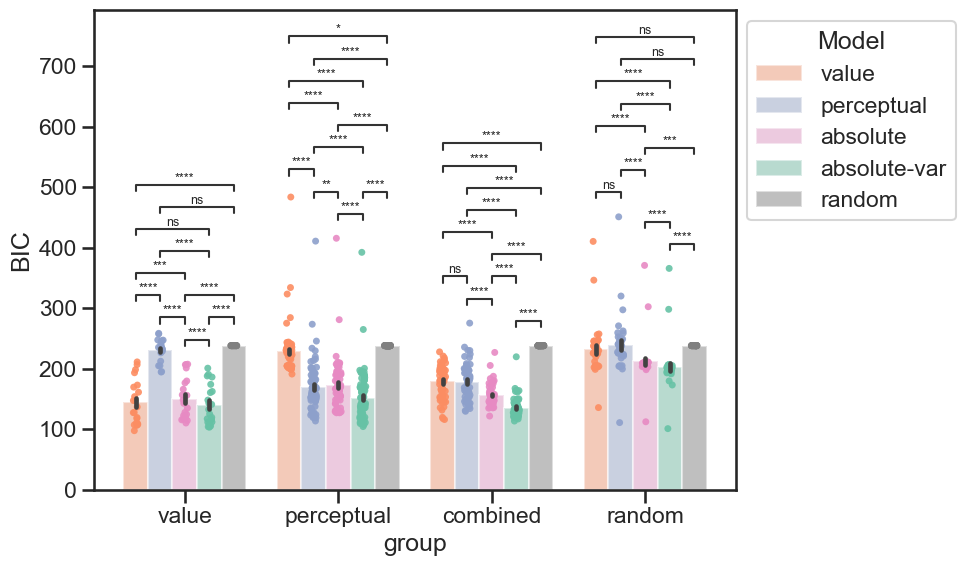

In [302]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    final_array = []
    for i in x:
        for j in hue:
            array = df[(df.group==i) & (df.model==j)].BIC.values
            final_array.append(array)

    return final_array



by_pid = dd.groupby(['agent', 'model', 'group']).ll.first().reset_index()
by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)


from groupBMC.groupBMC import GroupBMC

L = create_array(x=by_pid.group.unique(), hue=by_pid.model.unique(), df=by_pid)
hues = ['value', 'perceptual', 'absolute', 'absolute-var', 'random']

sns.set({'figure.figsize': (10, 6)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = ['value', 'perceptual', 'combined', 'random']
count = 0
count += 1
# Filter data for a specific experiment (e.g., 'FullPilot13') and plot
# plt.subplot(1, 2, 1)
sns.barplot(data=by_pid, x='group', y='BIC', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
ax = sns.stripplot(data=by_pid, x='group', y='BIC', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
            hue_order=hues, palette=['C1', 'C2', 'C3', 'C0', 'grey'])


x_values = by_pid['group'].unique()
hue_values = by_pid['model'].unique()
pairs = generate_combinations(x_values, hue_values)

annotator = Annotator(ax, pairs, data=by_pid, x='group', y='BIC', order=order, hue='model', hue_order=hues, loc='inside')
annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=9)
annotator.apply_and_annotate()

# plt.title(new_exp[exp])
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')


# put legend outside the plot

# plt.xticks([0, 1, 2], ['all or none', 'partial rew.', 'partial destroy'])
plt.tight_layout()
#change mo

In [237]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

## Group x model x exp

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

combined_absolute-var vs. combined_random: t-test paired samples, P_val:5.843e-08 t=-9.468e+00
random_absolute-var vs. random_random: t-test paired samples, P_val:8.637e-01 t=1.766e-01
random_value vs. random_perceptual: t-test paired samples, P_val:1.334e-02 t=-3.071e+00
perceptual_absolute vs. perceptual_absolute-var: t-test paired samples, P_val:5.904e-13 t=1.248e+01
combined_perceptual vs. combined_absolute: t-test paired samples, P_val:7.682e-03 t=3.047e+00
value_absolute vs. value_absolute-var: t-test paired samples, P_val:1.881e-02 t=3.818e+00
value_perceptual vs. value_absolute: t-test paired samples, P_val:1.416e-02 t=4.159e+00
value_absolute-var vs. value_random: t-test paired samples, P_val:4.752e-02 t=-2.826e+00
value_value vs. value_perceptual: t-test paired samples, P_val:1.472e-02 t

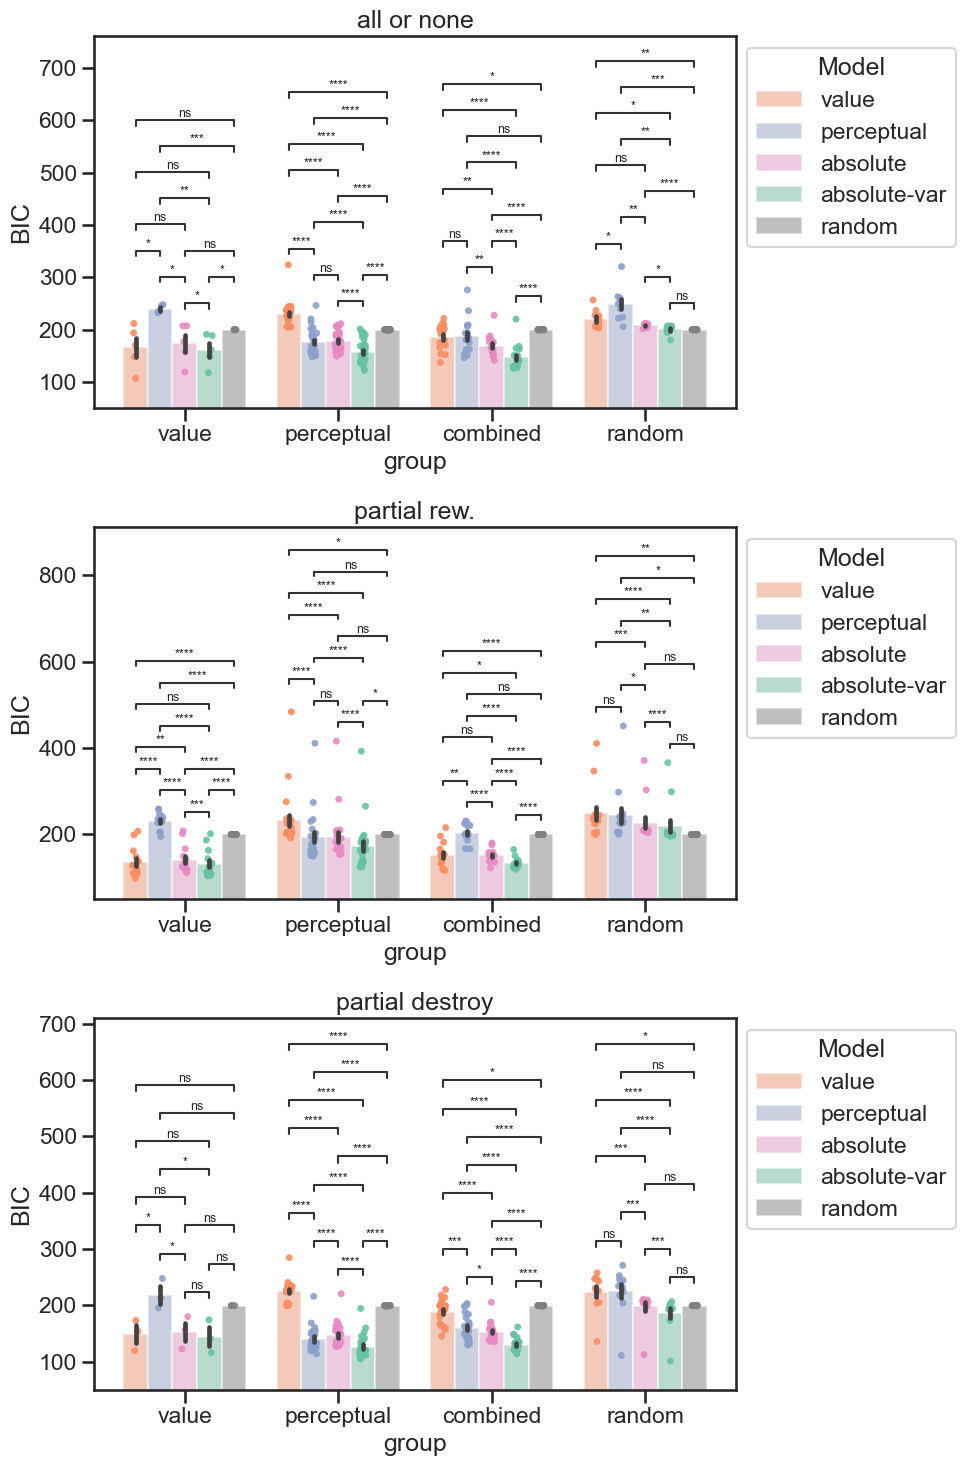

In [294]:
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import combinations
# import Annotator
from statannotations.Annotator import Annotator


def generate_combinations(x, hue):
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result


# Group by the necessary columns and compute first
by_pid = dd.groupby(['agent', 'model', 'expName', 'group']).ll.first().reset_index()

by_pid['n_param'] = by_pid.model.map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (10, 15)})
sns.set_context('talk')
sns.set_palette('Set2')
sns.set_style('ticks')
order = ['value', 'perceptual', 'combined', 'random']
hue_order = ['value', 'perceptual', 'absolute', 'absolute-var', 'random']
count = 0
for exp in ['FullPilot12', 'FullPilot13', 'FullPilot14']:
    count += 1
    plt.subplot(3, 1, count)
    # Filter data for a specific experiment (e.g., 'FullPilot13') and plot
    # plt.subplot(1, 2, 1)
    sns.barplot(data=by_pid[by_pid.expName==exp], x='group', y='BIC', hue='model', errorbar='se', alpha=0.5, zorder=-1, order=['value', 'perceptual', 'combined', 'random'],
             hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
    ax = sns.stripplot(data=by_pid[by_pid.expName==exp], x='group', y='BIC', hue='model', dodge=True, alpha=0.9, zorder=1,order=['value', 'perceptual', 'combined', 'random'],
              hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'])
    plt.ylim(50, 600)

    x_values = by_pid['group'].unique()
    hue_values = by_pid['model'].unique()
    pairs = generate_combinations(x_values, hue_values)

    annotator = Annotator(ax, pairs, data=by_pid[by_pid.expName==exp], x='group', y='BIC', order=order, hue='model', hue_order=hue_order, loc='inside')
    annotator.configure(test='t-test_paired', text_format='star', loc='inside', text_offset=0.01, fontsize=9)
    annotator.apply_and_annotate()
    new_exp = {
        'FullPilot12': 'all or none',
        'FullPilot13': 'partial rew.',
        'FullPilot14': 'partial destroy'
    }
    plt.title(new_exp[exp])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1, 1), handles=handles[:5], labels=labels[:5], title='Model', loc='upper left')


# put legend outside the plot

# plt.xticks([0, 1, 2], ['all or none', 'partial rew.', 'partial destroy'])
plt.tight_layout()
#change mo

In [27]:
dd.to_csv('../data/processed/fit_params_absolute_var_no_norm.csv', index=False)

# all pooled across models

In [57]:
dd.groupby('model').size()

model
absolute-var      380
perceptual-var    190
value-var         190
dtype: int64

In [60]:
dd.to_csv('../data/processed/fit_params_var.csv', index=False)

In [8]:
dd.groupby('model').size()

model
absolute      380
perceptual    190
value         190
dtype: int64

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

perceptual vs. absolute: t-test paired samples with Bonferroni correction, P_val:6.505e-04 t=3.922e+00
value vs. perceptual: t-test paired samples with Bonferroni correction, P_val:1.300e-03 t=3.712e+00
value vs. absolute: t-test paired samples with Bonferroni correction, P_val:1.299e-11 t=8.495e+00


C:\Users\basil\AppData\Local\Temp\ipykernel_38540\1455018783.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\1455018783.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\1455018783.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for

Text(0.5, 11.98958333333333, '')

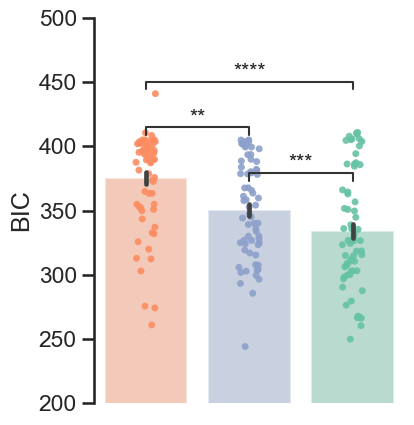

In [11]:
# Group by the necessary columns and compute first

# Filter the session data
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first
by_pid = dd[dd.expName=='FullPilot14'].groupby(['agent', 'model']).ll.first().reset_index()
by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (4, 5)})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

# hues = ['value', 'perceptual', 'absolute', 'absolute-var']
# hues = ['absolute-var', 'value-var', 'perceptual-var']
hues = ['value', 'perceptual', 'absolute']
palette = ['C1', 'C2', 'C0']
# palette = ['C1', 'C2', 'C3', 'C0', 'grey']
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
             order=hues, palette=palette)

plt.ylim(200, 500)
sns.despine()

x_values = by_pid['model'].unique()

# hue_values = by_pid['expName'].unique()
import itertools
pairs = list(itertools.combinations(x_values, 2))

from statannotations.Annotator import Annotator
annotator = Annotator(ax, pairs, data=by_pid, x='model', y='BIC', order=hues)
annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.02, text_offset=0.0001, line_offset_to_group=10, line_offset=10, fontsize=15)

annotator.apply_and_annotate()

sns.stripplot(data=by_pid,  y='BIC', x='model',alpha=0.9, zorder=1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
              order=hues, palette=palette, clip_on=False)
# plt.legend().remove()
sns.despine(bottom=True)
plt.xticks([], [])
plt.xlabel('')




p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

perceptual vs. absolute: t-test paired samples with Bonferroni correction, P_val:6.505e-04 t=3.922e+00
value vs. perceptual: t-test paired samples with Bonferroni correction, P_val:1.300e-03 t=3.712e+00
value vs. absolute: t-test paired samples with Bonferroni correction, P_val:1.299e-11 t=8.495e+00


C:\Users\basil\AppData\Local\Temp\ipykernel_38540\1455018783.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\1455018783.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
C:\Users\basil\AppData\Local\Temp\ipykernel_38540\1455018783.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for

Text(0.5, 11.98958333333333, '')

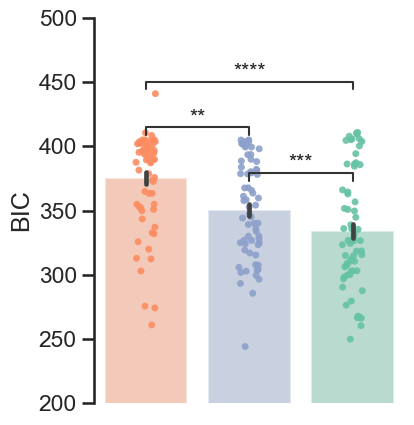

In [ ]:
# Group by the necessary columns and compute first

# Filter the session data
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first
by_pid = dd[dd.expName=='FullPilot12'].groupby(['agent', 'model']).ll.first().reset_index()
by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (4, 5)})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')

# hues = ['value', 'perceptual', 'absolute', 'absolute-var']
# hues = ['absolute-var', 'value-var', 'perceptual-var']
hues = ['value', 'perceptual', 'absolute']
palette = ['C1', 'C2', 'C0']


from groupBMC.groupBMC import GroupBMC

x = ['FullPilot12', 'FullPilot13', 'FullPilot14']   
hues = ['value', 'perceptual', 'absolute']
L = create_array(x=x,
                  hue=hues, df=by_pid)


for i in x:
    results = GroupBMC(-L[i]).get_result()
    for j in range(len(hues)):
        by_pid.loc[(by_pid.expName==i) & (by_pid.model==hues[j]), 'P(model)'] = results.attribution[j]
# palette = ['C1', 'C2', 'C3', 'C0', 'grey']
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, y='BIC', x='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
             order=hues, palette=palette)

plt.ylim(200, 500)
sns.despine()

x_values = by_pid['model'].unique()

# hue_values = by_pid['expName'].unique()
import itertools
pairs = list(itertools.combinations(x_values, 2))

from statannotations.Annotator import Annotator
annotator = Annotator(ax, pairs, data=by_pid, x='model', y='BIC', order=hues)
annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.02, text_offset=0.0001, line_offset_to_group=10, line_offset=10, fontsize=15)

annotator.apply_and_annotate()

sns.stripplot(data=by_pid,  y='BIC', x='model',alpha=0.9, zorder=1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
              order=hues, palette=palette, clip_on=False)
# plt.legend().remove()
sns.despine(bottom=True)
plt.xticks([], [])
plt.xlabel('')




In [39]:
dd.to_csv('../data/processed/fit_params_absolute_var_zscore.csv', index=False)

## model x exp

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

FullPilot14_absolute-var vs. FullPilot14_random: t-test paired samples with Bonferroni correction, P_val:1.127e-32 t=-2.443e+01
FullPilot13_absolute vs. FullPilot13_absolute-var: t-test paired samples with Bonferroni correction, P_val:1.632e-13 t=1.021e+01
FullPilot14_perceptual vs. FullPilot14_absolute: t-test paired samples with Bonferroni correction, P_val:9.357e-04 t=4.483e+00
FullPilot12_absolute vs. FullPilot12_absolute-var: t-test paired samples with Bonferroni correction, P_val:3.233e-19 t=1.409e+01
FullPilot12_perceptual vs. FullPilot12_absolute: t-test paired samples with Bonferroni correction, P_val:1.466e-06 t=6.239e+00
FullPilot12_absolute-var vs. FullPilot12_random: t-test paired samples with Bonferroni correction, P_val:5.466e-26 t=-1.934e+01
FullPilot12_value vs. FullPilot12_percep

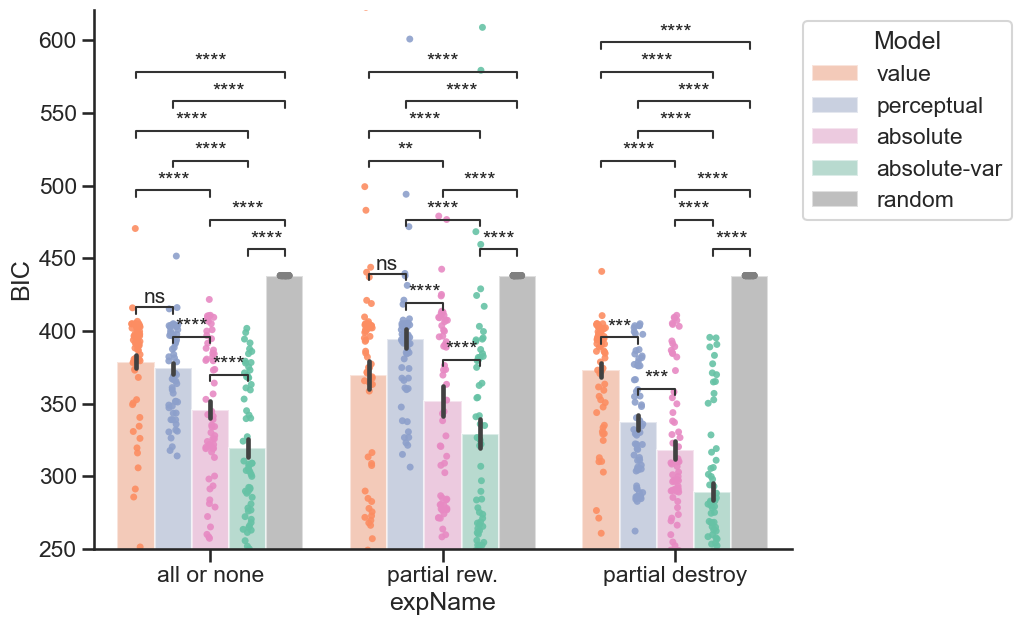

In [240]:
size = df[df.session.isin([0, 1, 2, 3])].groupby('prolificID').size()[0]
# Group by the necessary columns and compute first

by_pid = dd.groupby(['agent', 'expName', 'model']).ll.first().reset_index()

# model independent should be named absolute
# by_pid['model'] = by_pid['model'].map({'independent': 'absolute', 'single': 'single', 'log-ratio': 'log-ratio'})

by_pid['n_param'] = by_pid['model'].map(n_param)
by_pid['BIC'] = compute_bic(by_pid)

sns.set({'figure.figsize': (9, 7)})
sns.set_style('ticks')
sns.set_context('talk')
sns.set_palette('Set2')
# order = ['value', 'perceptual', 'combined', 'random']
order = ['FullPilot12', 'FullPilot13', 'FullPilot14']
hue_order = ['value', 'perceptual', 'absolute', 'absolute-var', 'random']
# plt.subplot(1, 2, 1)
ax = sns.barplot(data=by_pid, y='BIC',x='expName', hue='model', errorbar='se', alpha=0.5, zorder=-1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
             hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'], order=order)

plt.ylim(250, 475)
sns.despine()

x_values = by_pid['expName'].unique()
hue_values = by_pid['model'].unique()
# pairs = list(itertools.combinations(x_values, 2))
pairs = generate_combinations(x_values, hue_values)

annotator = Annotator(ax, pairs, data=by_pid, x='expName', hue='model', y='BIC', hue_order=hue_order, order=order)
annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.02, text_offset=0.0001, line_offset_to_group=10, line_offset=10, fontsize=15)

annotator.apply_and_annotate()

sns.stripplot(data=by_pid,  dodge=1, y='BIC', x='expName',alpha=0.9, hue='model', zorder=1, #order=['FullPilot12', 'FullPilot13', 'FullPilot14'],
              hue_order=hue_order, palette=['C1', 'C2', 'C3', 'C0', 'grey'], order=order)
# plt.legend().remove()
plt.xticks([0, 1, 2], ['all or none', 'partial rew.', 'partial destroy'])
# legend is outside
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1, 1), title='Model', loc='upper left', handles=handles[:5], labels=labels[:5])





# Parameters (beta_ss/beta_ff)

2
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

perceptual_$\beta_P$ vs. perceptual_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:2.256e-12 t=1.250e+01
value_$\beta_P$ vs. value_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:1.271e-02 t=-6.335e+00
combined_$\beta_P$ vs. combined_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=1.193e+00
random_$\beta_P$ vs. random_$\beta_V$: t-test paired samples with Bonferroni correction, P_val:1.000e+00 t=-1.010e+00


C:\Users\garciaba\AppData\Local\Temp\ipykernel_33280\3109253380.py:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.barplot(data=dd[(dd.expName==expName) & (dd.model == model)], x='group', y='value', hue='param',  dodge=True, ci=68, alpha=.8, zorder=-1, order=order)


Text(0.5, 1.0, 'hybrid-bayes model')

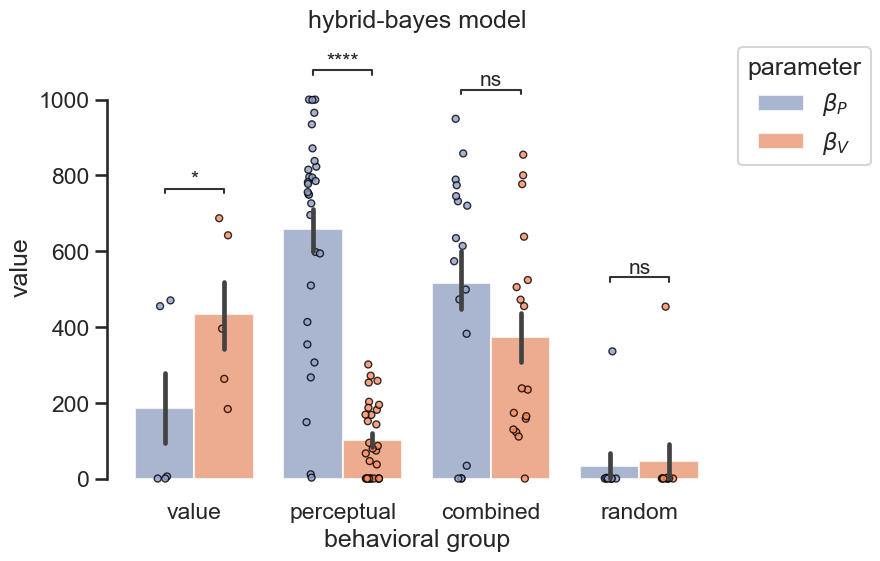

In [108]:
from statannotations.Annotator import Annotator
def generate_combinations(x, hue):
    from itertools import combinations
    result = []
    
    # Generate all combinations of elements from `x` with elements from `hue`
    for item in x:
        for comb in combinations(hue, 2):  # Generate combinations within `hue`
            result.append([(item, h) for h in comb])
    
    return result

def create_array(x, hue, df=None):
    final_array = []
    for i in x:
        for j in hue:
            array = df[(df.group==i) & (df.model==j)].values
            final_array.append(array)

    return np.array(final_array)



sns.set({'figure.figsize': (8,6), 'figure.dpi': 100})

sns.set_context('talk')
sns.set_style("ticks")
# change palette must be very different from set2
palette = sns.color_palette("Set2")
# only select the first 3 colors
palette = palette[1:3][::-1]
# palette = ['grey']
palette.append('#feabf2')
sns.set_palette(palette)

count_subplot = 0
model = 'absolute'
n_param = dd[(dd.model==model)].param2.unique().shape[0]
print(n_param)

# dd['expName'] = dd.expName.map({'FullPilot12': 'all or none', 'FullPilot13': 'partial rew.', 'FullPilot14': 'partial destroy'})
# dd = dd[dd.param2!='beta_ff']
# dd.loc[dd.param=='$\\beta_V$', 'param'] = '$\\beta$'

for expName in ['FullPilot12']:#, 'FullPilot13', 'FullPilot14']:
    count_subplot += 1
    plt.subplot(1, 1, count_subplot)
    sns.set_style("ticks")
    sns.set_context('talk')
    sns.set_palette(palette)
    order = ['value', 'perceptual', 'combined', 'random']
    sns.barplot(data=dd[(dd.expName==expName) & (dd.model == model)], x='group', y='value', hue='param',  dodge=True, ci=68, alpha=.8, zorder=-1, order=order)
    ax = sns.stripplot(data=dd[(dd.expName==expName) & (dd.model == model)], x='group', y='value', hue='param', jitter=0.1,alpha=.8, dodge=True, edgecolor='black', linewidth=1, zorder=1, order=order)
    plt.ylim(-50, 1050)

    x_values = dd[(dd.expName==expName) & (dd.model == model)]['group'].unique()
    hue_values = dd[(dd.expName==expName) & (dd.model == model)]['param'].unique()
# pairs = list(itertools.combinations(x_values, 2))
    pairs = generate_combinations(x_values, hue_values)

    annotator = Annotator(ax, pairs, data=dd[(dd.expName==expName) & (dd.model == model)], x='group', hue='param', y='value',order=order)
    annotator.configure(test='t-test_paired', text_format='star', loc='inside',comparisons_correction="Bonferroni",
                    line_height=0.01, text_offset=0.0001, line_offset_to_group=50, line_offset=50, fontsize=15)

    annotator.apply_and_annotate()

    handles, labels = plt.gca().get_legend_handles_labels()
    # increase the size of the markers

    plt.legend().remove()

    sns.despine(trim=True, bottom=True)
    plt.tick_params(axis='x', length=0)
    if expName=='FullPilot12':
        plt.title('all or none')
    if expName=='FullPilot13':
        plt.title('partial rew.')
    if expName=='FullPilot14':
        plt.title('partial destroy')
    # plt.title(expName)

# plt.legend(handles[2:], labels[2:], title='Parameter', loc='upper left', bbox_to_anchor=(1, 1), markerscale=2.5)
# legent horizontal position outside
plt.legend(handles=handles[:n_param], labels=labels[:n_param], title='parameter', loc='upper left', bbox_to_anchor=(1, 1), markerscale=2.5)
plt.xlabel('behavioral group')
# legend flat and horizontal

# plt.suptitle('Model: {}'.format(model))
# plt.title('Model: {}'.format(model))
plt.title('hybrid-bayes model')
# plt.tight_layout()

In [ ]:
model = 'absolute'
# avg = df_sim.groupby(['agent', 'model'], as_index=False).mean(numeric_only=True)
avg_sim = df_sim[df_sim.session==3].groupby(['agent', 'model'], as_index=False).mean(numeric_only=True)

avg = df[df.session==3].groupby(['prolificID'], as_index=False).mean(numeric_only=True)

for pid in avg.prolificID.unique():
    avg.loc[avg.prolificID==pid, 'beta_ss'] = avg_sim[(avg_sim.agent==pid) & (avg_sim.model==model)].beta_ss.values[0]
    avg.loc[avg.prolificID==pid, 'beta_ff'] = avg_sim[(avg_sim.agent==pid) & (avg_sim.model==model)].beta_ff.values[0]

# change color of lmplot
colors = sns.color_palette("Set2")
sns.set_palette([colors[1]])
sns.lmplot(x='beta_ss', y='opti_ss', data=avg, fit_reg=True)
plt.ylim(0,1)
# pearson corr
import scipy.stats as stats

r, p = stats.spearmanr(avg.beta_ss, avg.opti_ss)

plt.text(0.5, 0.9, f'r={r:.2f}, p={p:.3f}')

plt.xlabel('$\\beta_{V}$')
plt.ylabel('p(optimal spaceship)') 

In [7]:
dd = pd.read_csv('../data/processed/fit_params.csv')

Text(52.000000000000014, 0.5, 'p(optimal spaceship)')

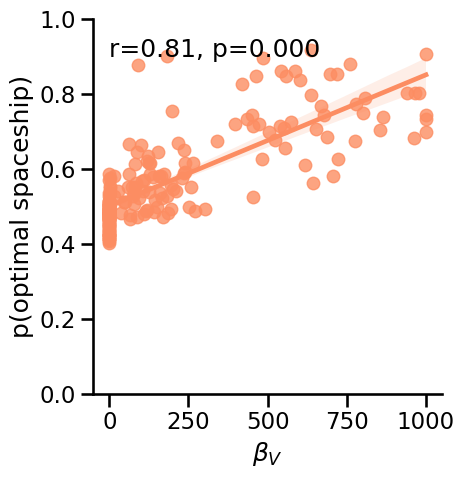

In [12]:
opti_ss = df.groupby(['prolificID', 'session'], as_index=False).opti_ss.mean()
opti_ff = df.groupby(['prolificID', 'session'], as_index=False).opti_ff.mean()
opti_ss = opti_ss[opti_ss.session==3]
opti_ff = opti_ff[opti_ff.session==3]
param = []

model = 'absolute'
# add the optimal ss to the data dd
for agent in opti_ss.prolificID:
    param.append(
        {
            'opti_ss': opti_ss[opti_ss.prolificID==agent].opti_ss.values[0],  
            'opti_ff': opti_ff[opti_ff.prolificID==agent].opti_ff.values[0],
            'agent': agent,
            'model': model,
            'beta_ff': dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ff')].value.values[0],
            'beta_ss': dd[(dd.agent==agent) & (dd.model==model) & (dd.param2=='beta_ss')].value.values[0],
        }
    )

param = pd.DataFrame(param)

# remove the cutoff
# change color of lmplot
colors = sns.color_palette("Set2")
sns.set_context('talk')
sns.set_palette([colors[1]])
sns.lmplot(x='beta_ss', y='opti_ss', data=param, fit_reg=True)
plt.ylim(0,1)
# pearson corr
import scipy.stats as stats

r, p = stats.spearmanr(param.beta_ss, param.opti_ss)

plt.text(0.5, 0.9, f'r={r:.2f}, p={p:.3f}')

plt.xlabel('$\\beta_{V}$')
plt.ylabel('p(optimal spaceship)') 

Text(29.140624999999993, 0.5, 'p(optimal shield)')

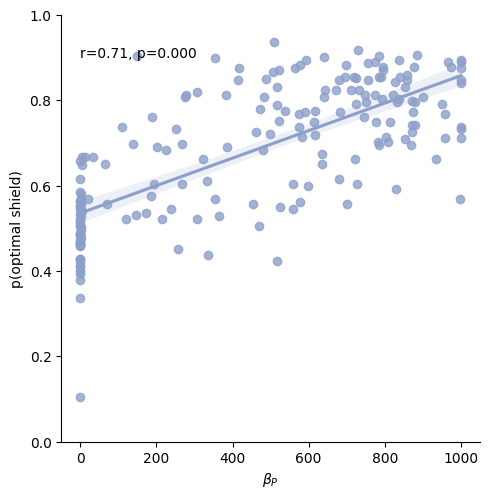

In [11]:
# remove the cutoff
# change color of lmplot
colors = sns.color_palette("Set2")

sns.set_palette([colors[2]])
sns.lmplot(x='beta_ff', y='opti_ff', data=param, fit_reg=True)
plt.ylim(0,1)
# pearson corr
import scipy.stats as stats

r, p = stats.spearmanr(param.beta_ff, param.opti_ff)

plt.text(0.5, 0.9, f'r={r:.2f}, p={p:.3f}')

plt.xlabel('$\\beta_{P}$')
plt.ylabel('p(optimal shield)') 

In [ ]:
# count proportion of beta_ss at bounds
param[(param.beta_ff<1) | (param.beta_ff>990000)].shape[0] / param.shape[0]


In [ ]:
# t-test in fullpilot12 for group value between beta_p and beta_v
pg.ttest(x=dd[(dd.expName=='FullPilot12') & (dd.group=='value') & (dd.model=='log-ratio') & (dd.param=='$\\beta_P$')].value,
         y=dd[(dd.expName=='FullPilot12') & (dd.group=='value') & (dd.model=='log-ratio') & (dd.param=='$\\beta_V$')].value)

In [157]:
df['opti_ev'] = ((df.choice==1) & (df.ev1 > df.ev2)) | ((df.choice==2) & (df.ev2 > df.ev1))

In [ ]:
sns.set({'figure.figsize': (10, 14.5), 'figure.dpi': 100})

sns.set_context('talk')
sns.set_style("ticks")
# change palette must be very different from set2
palette = sns.color_palette("Set2")
# only select the first 3 colors
palette = palette[1:3][::-1]
# palette = ['grey']
palette.append('#feabf2')
sns.set_palette(palette)

count_subplot = 0
model = 'independent'

# dd['expName'] = dd.expName.map({'FullPilot12': 'all or none', 'FullPilot13': 'partial rew.', 'FullPilot14': 'partial destroy'})
# dd = dd[dd.param2!='beta_ff']
# dd.loc[dd.param=='$\\beta_V$', 'param'] = '$\\beta$'

# melt to have a opti and value column, where opti = ff, ss, ev and value = value
df3 = df[df.expName.isin(['FullPilot14']) & (df.session==3)].groupby(['agent', 'group'], as_index=False).mean(numeric_only=True)
# df3 = df.melt(id_vars=['agent', 'group'], value_vars=['opti_ff', 'opti_ss', 'opti_ev'], var_name='opti', value_name='value')
# df3 = df3.groupby(['agent', 'group'], as_index=False).mean(numeric_only=True).reset_index()
df3 = pd.melt(df3,
                   id_vars=['agent', 'group'], value_vars=['opti_ff', 'opti_ss', 'opti_ev'], var_name='opti', value_name='value')

# df3 = df3.groupby(['agent', 'group', 'opti'], as_index=False).value.mean().reset_index()
palette = sns.color_palette("Set2")
palette = palette[0:3][::-1]
for expName in ['FullPilot14']:
    count_subplot += 1
    plt.subplot(3, 1, count_subplot)
    sns.set_style("ticks")
    sns.set_context('talk')
    sns.set_palette(palette)
    order = ['perceptual', 'value', 'combined', 'random']
    sns.barplot(data=df3, x='group', y='value', hue='opti',  dodge=True, alpha=.8, errorbar='se', zorder=-1, order=order)
    sns.stripplot(data=df3, x='group', y='value', hue='opti', jitter=0.1,alpha=.8, dodge=True, edgecolor='black', linewidth=1, zorder=1, order=order)
    plt.ylim(-.05, 1.05)

    handles, labels = plt.gca().get_legend_handles_labels()
    # increase the size of the markers


    plt.legend(handles[3:], labels[3:], title='variable', loc='upper left', bbox_to_anchor=(1, 1), markerscale=2.5)
    sns.despine(trim=True, bottom=True)
    plt.tick_params(axis='x', length=0)
    # hline
    plt.axhline(0.5, color='grey', linestyle='--')
    

    if expName=='FullPilot12':
        plt.title('all or none')
    if expName=='FullPilot13':
        plt.title('partial rew.')
    if expName=='FullPilot14':
        plt.title('partial destroy')

plt.tight_layout()

In [ ]:
df3

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(rc={'figure.figsize':(5, 4), 'figure.dpi':300})
# set all fonts bigger
sns.set_context('talk')
sns.set_style('ticks')
# sns.set_style('dark')
# plt.style.use('dark_background')
# sns.set_palette('dark')
# sns.set_theme(style='dark')



def plot(y='value', hue='param', df=None):
    sns.violinplot(y=y, x='expName', hue=hue, zorder=-1, data=df, alpha=.6, linecolor='w', bw=0.5, gap=.1, split=True, 
                     inner_kws={'color': 'black', 'linewidth': 0.5}, palette=['C0', 'C1'], inner=None)
    ax=sns.pointplot(y=y, x='expName', hue=hue, zorder=2, data=df, dodge=True, ci=68, estimator=np.mean, markers='o', scale=1.3, color='black')
    m1 = df[df.param=='$\\beta_P$'].groupby('expName').mean(numeric_only=True).reset_index()
    m2 = df[df.param=='$\\beta_V$'].groupby('expName').mean(numeric_only=True).reset_index()
    # get x positon of the pointplot

    plt.scatter([-.025], m1.value, zorder=3, s=40, color='white')
    plt.scatter([.025], m2.value, zorder=3, s=40, color='white')
    ax = sns.stripplot(y=y, x='expName', hue=hue, zorder=1, size=10, 
                    data=df,dodge=True, edgecolor='white', linewidth=1, palette=['C0', 'C1'])
    # connect swarm dots with grey lines
    xlim = plt.xlim()
    # trace_lines_between_dots(df, y=y)
    # sns.lineplot(y=y, 
                #  x='expName', hue='pair2', zorder=2, style='pair2', 
                #    data=df_, alpha=1, color='grey', units='prolificID', estimator=None, legend=False
                #    )
    plt.xlim(xlim)
    trace_lines_between_dots(y=y, df=df)
    # plt.ylim(-.1, 1.1)
    # sns.pointplot(y=y, x='expName', hue='pair2', zorder=2, data=df_, dodge=True, ci=None, estimator=np.mean, markers='o', scale=1.5)
    
def get_x_from_y(y_value, ax, i):
    # Get the PathCollection (which contains the points' positions)
    collection = ax.collections[0]
    paths = collection.get_offsets()

    # Convert to a numpy array of points (x, y)
    points = np.array(paths)
    # Find the index of the closest point in terms of y value
    idx = (np.abs(points[:, 1] - y_value)).argmin()
    # Return the corresponding x value
    return points[idx, 0]      

# trace grey lines between hue categories swarm dots
# to do that we need to get the x position of each prolificID in the swarmplot
# and then draw a line between each pair of dots
def trace_lines_between_dots(y='opti_ss', ax=None, df=None):
    p1, p2 = df.param.unique()
    for j, expname in enumerate(np.sort(df.expName.unique())):
        for i, name in enumerate(df[df.expName==expname].agent.unique()):
            d1 = df[(df.agent==name) & (df.expName==expname) & (df.param==p1)]['value']
            assert len(d1) == 1
            d2 = df[(df.agent==name) & (df.expName==expname) & (df.param==p2)]['value']
            assert len(d2) == 1
            # d3 = df[(df.prolificID==name) & (df.expName==expname) & (df.y=='opti_ev')]['value']
            y2 = d2.values[0]
            y1 = d1.values[0]
            # y3 = d3.values[0]
            if ax:
                #this is the scatterplot ax
                # get the x position of the dot using y1, y2, y3
                # Function to find the x value corresponding to a given y value
                x1 = get_x_from_y(y1, ax, i)
                x2 = get_x_from_y(y2, ax, i)
                x3 = get_x_from_y(y3, ax, i)      
                plt.plot([x1, x2, x3], [y1, y2, y3], 'grey', alpha=.4)
                continue
                
            plt.plot([j-.15, j+.15], [y1, y2], 'grey', alpha=.4, zorder=-1)


# plt.subplot(1, 3, 1)
sns.set(rc={'figure.figsize':(5, 4), 'figure.dpi':300})

sns.set_context('talk')
sns.set_style('ticks')

#plt.plot([-0.5, len(df.session.unique())+.5], [0.5, 0.5], 'k--', alpha=0.5) 
# plt.plot([-0.5, 0.5], [0.5, 0.5], 'k--', alpha=0.5) 
dd = pd.read_csv('../data/processed/fit_params_fullpilot13.csv')
plot(y='value', df=dd)
plt.ylabel('Parameter strength')
sns.despine()
plt.xlabel('')
plt.xticks([])
#45 degree xticks
# plt.xticks(rotation=45)
# plt.legend([],[], frameon=False)
# only keep first two legend handles
handles = plt.gca().get_legend_handles_labels()[0]
# plt.legend(handles[0:3], ['spaceship', 'shield', 'optimal ev'], title='', loc='lower center', fontsize=12, title_fontsize=12)
# handle size
plt.xlabel('')

plt.tick_params(axis='x', length=0)
sns.despine(bottom=True)
# plt.xticks([0], ['session 1'])
param = dd.param.unique()
plt.legend(handles[:2][::-1], param[::-1], title='Parameter', bbox_to_anchor=(.01, -0.2), loc='lower left')
print(yticks)
plt.yticks(yticks)
# plt.legend().remove()

In [ ]:
from scipy.stats import ttest_rel
ttest_rel(dd[dd.param=='$\\beta_P$'].value, dd[dd.param=='$\\beta_V$'].value)

In [ ]:
# make a dataframe with the fitted values that are arrays of length 2 in a dic then convert to a dataframe
ddd = []
norm = lambda x: (x - x.min()) / (x.max() - x.min())
for agent, value in xopt.items():
    if agent not in df.prolificID.values:
        continue
    delta = value[0] - value[1]
    ddd.append({
        'agent': agent,
        'expName': df[df.prolificID==agent].expName.values[0],
        # 'model': 'NormativeEV',
        'opti_ff': value[0],
        'opti_ss': value[1],
    })
    
ddd = pd.DataFrame(ddd)

ddd['opti_ff'] = norm(ddd.opti_ff)
ddd['opti_ss'] = norm(ddd.opti_ss)
ddd['delta'] = ddd.opti_ff - ddd.opti_ss

# ddd['group'] = ddd.apply(lambda x:'perceptual' if x.delta > 0.1 else 'value' if x.delta < -0.1 else 'combined', axis=1)
ddd['group'] = None
ddd.to_csv('../data/processed/fitting_FullPilot12.csv', index=False)


In [ ]:
group_df = pd.read_csv('../data/processed/df_fullpilot12.csv')

# set group from group_df to ddd using prolificID and agent columns
ddd['group'] = ddd.apply(lambda x: group_df[group_df.prolificID==x.agent].group.values[0], axis=1)

In [ ]:
# same but with scatterplot
sns.set(rc={'figure.figsize':(5,4)})
sns.set_context("talk")
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Function to create hand-drawn-like regions
def draw_handdrawn_region(center, hue, ax, radius=0.09, irregularity=0.004):
    # Generate random points around the center
    center = (center[0].mean(), center[1].mean())

    angles = np.linspace(0, 2 * np.pi, 20)
    # make it elliptical
    radius_x = radius - (radius/2)
    radius_y = radius + (radius/2)
    x_offsets = radius_x * np.cos(angles) + np.random.randn(20) * irregularity
    y_offsets = radius_y * np.sin(angles) + np.random.randn(20) * irregularity
    region_x = center[0] + x_offsets
    region_y = center[1] + y_offsets
    
    # clip the region to the axes boundaries in order to get oval shapes instead of circles
    # use max to cut off like 30% of the region

    # Fill the hand-drawn region with alpha
    ax.fill(region_x, region_y, color=hue, alpha=0.2, linewidth=0, zorder=2)

def draw_contour_region(center, hue, ax, radius=0.07):
    # Create a grid of points around the center
    x = np.linspace(center[0] - radius, center[0] + radius, 100)
    y = np.linspace(center[1] - radius, center[1] + radius, 100)
    X, Y = np.meshgrid(x, y)
    
    # Create a multivariate normal distribution for contour
    pos = np.dstack((X, Y))
    rv = multivariate_normal([center[0], center[1]], [[radius, 0], [0, radius]])
    Z = rv.pdf(pos)
    
    # Plot contourf for filled contours
    ax.contourf(X, Y, Z, levels=2, colors=hue, alpha=0.2)


df_ = ddd

# sort by group 
order = ['perceptual', 'combined', 'value', 'random']
df_['group'] = pd.Categorical(df_['group'], categories=order, ordered=True)
scatter = sns.scatterplot(data=df_, x='opti_ss', y='opti_ff', hue='group', palette=['C0', 'C2', 'C1', 'C7'], s=100)

# hightlight the clusters
# plt.axvline(0.5, color='gray', linestyle='--', alpha=0.2)
# plt.axhline(0.5, color='gray', linestyle='--', alpha=0.2)

# hightlight the clusters
# using seaborn, we want a region of interest using the colors of the clusters in scatterplot
sns.kdeplot(data=df_, x='opti_ss', y='opti_ff', alpha=0.2, fill=True, palette=['C0', 'C2', 'C1', 'C7'], hue='group', levels=2, bw_adjust=0.6, thresh=0.001) 
# Draw kdeplot for clusters with sufficient points

# change legend labels to add N=xx
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f'{label} ({len(df_[df_.group==label])})' for label in labels]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1)
           , loc=2, borderaxespad=0.)
data = df_
data['hue'] = data['group']
data['x'] = data['opti_ss']
data['y'] = data['opti_ff']
for hue_value in data['hue'].unique():
    
    subset = data[data['hue'] == hue_value]
    # For small groups, draw manual circles
    if len(subset) <= 2:
             # For small groups, draw hand-drawn regions
        draw_handdrawn_region((subset['x'], subset['y']), 'C2', plt.gca())
            


# add a third dimension (opti_ev)
# plt.ylim(0.3, 1)
# plt.xlim(0.3, 1)
plt.xlabel('p(optimal spaceship)')
plt.ylabel('p(optimal shield)')
# put legend outside
N = len(data)
# plt.title(f'counterfactual+R/2; N={N}')

#no legend
# plt.legend().remove()

In [ ]:
import matplotlib.pyplot as plt
# plot group distribution
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("ticks")
sns.set_context('talk')
# create new df with count of participants in each group
df_ = ddd.groupby(['group']).size().reset_index(name='count')
order = ['perceptual', 'value', 'combined']
df_['group'] = pd.Categorical(df_['group'], categories=order, ordered=True)
# sort by count
df_ = df_.sort_values('count', ascending=False)
sns.barplot(data=df_, x='group', y='count', palette=['C0', 'C1', 'C2'])
plt.xticks(rotation=45)
plt.ylabel('Number of participants')

# annotate with count of participants
# order is 1=perceptual, 2=balanced, 3=value
for i, row in df_.iterrows():
    order_idx = order.index(row['group'])
    # plt.text(order_idx, row['count'], row['count'], ha='center')
    # annotate with count of participants
    # for each hue, so 6 annotations, 2 for each hue
    plt.text(order_idx, row['count'], row['count'], ha='center', va='bottom')
    # the above is centered, we want to offset to left and right according to hue, so 
    # if i % 2 == 0, then offset to the left, else offset to the right
    # offset = -0.2 if i % 2 == 0 else 0.2
    # plt.text(order_idx + offset, row['count'], row['count'], ha='center', va='bottom')

sns.despine(trim=True)

In [ ]:
# print likelihood function
# -----------------------------------------------------------------
# parameters to tune
import itertools
from pybads import BADS
import scipy.optimize as opt
from tqdm.notebook import tqdm
# timeit

pbar = tqdm(total=len(df.agent.unique()))

#install IPyWidgets

# space = np.arange(0, 100, 5)
space = np.linspace(0, 20, 20)
space_all = np.array(list(itertools.product(space, repeat=2)))
# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

xopt = {}
for agent in df.agent.unique():
    df2 = df[df.agent==agent]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = df2.shape[0]

    # xopt, fopt, fn1 = minimize(
        # f=fit,
        # args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space)
    
    # ...
    def target(x):
        return fit_pwf(x, *(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()))[0]

    lower_bounds = np.array([-10, -10])
    upper_bounds = np.array([10, 10])
    plausible_lower_bounds = np.array([1.0, 1.0])
    plausible_upper_bounds = np.array([5., 5.])
    # Starting point
    x0 = np.array([0, 0]);        

    bads = BADS(
        target,
        x0=x0[:1],
        lower_bounds=lower_bounds[:1],
        upper_bounds=upper_bounds[:1],
        # plausible_lower_bounds=plausible_lower_bounds[:1],
        # plausible_upper_bounds=plausible_upper_bounds[:1],
        options={'display': 'off'}
    )
    
    # xopt[agent] = opt.minimize(target, x0[:1], bounds=[(-10, 10)]).x[0]

    optimize_result = bads.optimize()
    
    xopt[agent] = optimize_result.x[0]
    continue

    # d.append({
        # 'agent': agent,
        # 'model': 'NormativeEV',
        # 'param': 'temp',
        # 'value': xopt
    # })

    # for i in range(len(fn1)):
    #     d.append({
    #         'agent': agent,
    #         'model': 'NormativeEV',
    #         # 'original_model': df2.model.values[0],
    #         'fn': fn1[i],
    #         'space': space[i],
    #     }) 

    xopt, fopt, params, fn2 = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2, map_ff_values.values()), space=space_all)
    # # print(xopt)
    d.append({
        'agent': agent,
        'model': 'NormativeLogRatio',
        'param': 'rl_temp',
        'value': xopt[1],
        'params': params
    })
    
    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeLogRatio',
    #     'param': 'perceptual_temp',
    #     'value': xopt[0],
    #     'params': params
    # })
    # # print(res)
    """ for i in range(len(fn2)):
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            # 'original_model': df2.model.values[0],
            'fn': fn2[i],
          'param': 'rl_temp',
          'value': space_all[i][1]
        }) 
        d.append({
            'agent': agent,
            'model': 'NormativeLogRatio',
            'fn': fn2[i],
            'param': 'perceptual_temp',
            'value': space_all[i][0]
        })
 """
    pbar.update()


d = pd.DataFrame(d)
pbar.refresh()


In [ ]:
# display function with slope = mean(xopt)
import matplotlib.pyplot as plt

logistic = lambda slope, x: 1/(1+np.exp(-slope*x))
x = np.linspace(-1, 1, 12).round(2)
slope = np.mean(list(xopt.values())).round(2)
# slope = xopt['5610c4ea7ffc8a0005811504']

sns.set({'figure.figsize': (3, 2.5), 'figure.dpi': 200})
sns.set_style('ticks')

ax = plt.gca()
for agent, value in xopt.items():
    ax.plot(x, logistic(value, x), alpha=.2, color='black', label='fitted sub')
ax.plot(x, logistic(slope, x), label=f'fitted avg slope={slope}', color='C0')
# plot true slope = 2
ax.plot(x, logistic(2, x), label='true slope=2', color='C1')
ax.set_xlabel('Forcefield values')
ax.set_ylabel('P(destroy)')
ax.set_title('pwf')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# keep only last three for legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc='upper left', bbox_to_anchor=(1, 1))
# loc of legend outside plot
print(xopt)

In [ ]:
df[df.prolificID=='5c5ac2869d974300015d81fc'].correct.mean()

In [ ]:
import scipy.optimize as opt
# i have probabilities (y)
# i need to find the x values that correspond to these probabilities
# i.e. the x values that give me the y values through the logistic function
# and find the slope that minimizes the difference between the x values and the forcefield values

x = np.unique([df.ff1.values, df.ff2.values])
y = np.unique([df.p1.values, df.p2.values])

def f(slope, x, y):
    return np.sum(np.abs(logistic(slope, x) - y))
    
opt.minimize(f, 0, args=(x, y))


In [ ]:
sns.set({'figure.figsize': (1, 2.5), 'figure.dpi': 200})
sns.set_style('ticks')

sns.boxplot(x='param', y='value', data=d)
# sns.stripplot(x='param', y='value', data=d,alpha=.9, palette='Set2')

In [ ]:
#plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[d.model=='NormativeEV']
plt.figure(figsize=(10, 3), dpi=100)
sns.lineplot(x='space', y='fn', data=dd, n_boot=0)
plt.ylabel('log likelihood')
plt.xlabel('$\\beta$')
plt.xticks(space)

# plt.xticks(space)


In [ ]:
# plot heatmap of liklihood (fn) for each parameter value (space)
dd = d[(d.model=='NormativeLogRatio') & (d.original_model!='random')]
plt.figure(figsize=(15, 5), dpi=300)
count = 0
for model in dd.original_model.unique():
    count += 1
    ddd = dd[dd.original_model==model].pivot(index='perceptual_temp', columns='rl_temp', values='fn')
    # change index and columns to int
    ddd.columns = ddd.columns.astype(int)
    ddd.index = ddd.index.astype(int)
    # xy = ddd.space.values
    # stack xy as a 2d array
    # xy = np.vstack(xy)
    # z = ddd.fn.values

    # plot heatmap
    plt.subplot(1, len(dd.original_model.unique()), count)
    # rs = len(space)
    
    plt.title(f'original_model={model}')
    ax = sns.heatmap(ddd,square=True, annot=True, annot_kws={"size": 4}, fmt='.1f', vmax=30, vmin=0)
    d_ = np.asarray(ddd)
    y,x = np.unravel_index(d_.argmin(), d_.shape)
    ax.add_patch(plt.Rectangle((x, y), 1, 1, fc='none', ec='skyblue', lw=5, clip_on=False))


space_all[np.argmin(ddd)]

In [ ]:
# manual fit
# -----------------------------------------------------------------
# parameters to tune
import itertools

pbar = tqdm(total=len(df.agent.unique()))
space = np.concatenate([np.linspace(0, 10, 10), np.linspace(10, 50, 5)]).flatten().round(1)
print(space)
space_all = np.array(list(itertools.product(space, repeat=2)))

# import pyfmincon.opt
# pyfmincon.opt.connect()
d = []

for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=1, space=space)
    
    d.append({
            'agent': agent,
            'model': 'NormativeEV',
            'original_model': df2['model'].values[0],
            'll': fopt,
            'fitted_temp': float(xopt),
            'temp': df2['temp'].values[0],
    })

    xopt, fopt = minimize(
        f=fit,
        args=(ntrials, s, a, r, destroy, ff1, ff2), nparam=2, space=space_all)
    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)


In [ ]:
# parameter retrieval
import scipy.optimize as opt
# import fit


models = (NormativeLogRatio, )
pbar = tqdm(total=len(df.agent.unique()))
method = 'scipy'
ub = [100]
lb = [.001]
x0 = np.mean([ub, lb], axis=0).tolist()

import pyfmincon.opt
pyfmincon.opt.connect()
d = []


for agent in df.agent.unique():

    df2 = df[(df.agent==agent)]
    s, a, r = df2.s.values, df2.a.values, df2.r.values
    ff1, ff2 = df2.ff1.values, df2.ff2.values
    destroy = df2.destroy.values
    ntrials = int(df2.trial.max())

    # if method == 'matlab':
    #     x = pyfmincon.opt.fmincon(
    #             function='fit.fit',
    #             x0=x0,
    #             optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
    #             lb=lb,
    #             ub=ub,
    #             options={}
    #     )
    #     xopt = x[0]
    #     fopt = x[1]


    # if method == 'scipy':
    #     res = opt.minimize(
    #         fit,
    #         x0,
    #         args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
    #         bounds=[(0, 10)])
    #     # xopt, fopt = matlab.fmincon(
    #     xopt = res.x[0]
    #     fopt = res.fun

    # d.append({
    #     'agent': agent,
    #     'model': 'NormativeEV',
    #     'original_model': df2['model'].values[0],
    #     'll': fopt,
    #     'fitted_temp': float(xopt),
    #     'temp': df2['temp'].values[0],
    # })

    if method == 'matlab':
        x = pyfmincon.opt.fmincon(
                function='fit.fit2',
                x0=x0 * 2,
                # optional_args=[ntrials, s, a.astype(int), r, destroy.astype(int), ff1, ff2],
                optional_args=[ntrials, s],
                lb=lb * 2,
                ub=ub * 2,
                options={}
        )
        xopt = x[0]
        fopt = x[1]

    if method == 'scipy':
        res = opt.minimize(
            fit,
            x0 * 2,
            args=(ntrials, s, a, r, destroy, ff1, ff2), method='L-BFGS-B',
            bounds=[(0, 30), (0, 30)], options=dict(ftol=1e-8))
        
        xopt = res.x
        fopt = res.fun

    # print(res)
    d.append({
        'agent' : agent,
        'model': 'NormativeLogRatio',
        'original_model': df2['model'].values[0],
        'll': fopt,
        'fitted_rl_temp': xopt[1],
        'fitted_perceptual_temp': xopt[0],
        'rl_temp': df2['rl_temp'].values[0],
        'perceptual_temp': df2['perceptual_temp'].values[0],
    })

    pbar.update()

pbar.refresh()

d = pd.DataFrame(d)
d.to_csv('data/fit.csv', index=False)

In [ ]:
# select 30 perceptual neglect
d = pd.read_csv('data/fit.csv')
np.random.seed(1)
n = 30
d1 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')].sample(n=n)
assert len(d1.agent.unique()) == n
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='value neglect')].sample(n=n)
assert len(d2.agent.unique()) == n
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='balanced')].sample(n=n)
assert len(d3.agent.unique()) == n
d4 = d[(d.model=='NormativeLogRatio') & (d.original_model=='random')].sample(n=n)
assert len(d3.agent.unique()) == n



models = [d1, d2, d3, d4]

# d_full = pd.DataFrame()
# d_full['parameter'] = ['perceptual_temp', ] * n
# d_full['value'] = d1.
d_full = pd.concat(models)
length = len(d_full)
dfull = pd.DataFrame()
dfull['parameter'] = ['$\\beta_P$', ] * length + ['$\\beta_V$', ] * length
dfull['value'] = d_full['fitted_perceptual_temp'].tolist() + d_full['fitted_rl_temp'].tolist()
dfull['model'] = d_full['original_model'].tolist() * 2

# remove outliers using stats zscore
from scipy import stats
dfull['z'] = np.abs(stats.zscore(dfull['value']))
# dfull = dfull[dfull.z < 3]


plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
# increase axes width
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
# increase font size
plt.rcParams.update({'font.size': 15})
sns.set_palette('deep')
palette = ['C2', 'C0', 'C1', 'grey']
sns.set_palette(palette=palette)

dfull1 = dfull[dfull.model=='balanced']
plt.subplot(1, 3, 1)
sns.barplot(x='parameter', y='value', data=dfull1, zorder=0, color='C0', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull1,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C0')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('balanced')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)

dfull2 = dfull[dfull.model=='value neglect']
plt.subplot(1, 3, 3)
sns.barplot(x='parameter', y='value', data=dfull2, zorder=0, color='C1', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull2,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C1')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('perceptual maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)


dfull3 = dfull[dfull.model=='perceptual neglect']
plt.subplot(1, 3, 2)
sns.barplot(x='parameter', y='value', data=dfull3, zorder=0, color='C2', alpha=.5)
sns.stripplot(x='parameter', y='value', data=dfull3,alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, color='C2')
plt.ylabel('value')
plt.xlabel('fitted parameter')
plt.title('value maximizer')
sns.despine(trim=True, bottom=True)
plt.tick_params(axis='x', length=0)



plt.tight_layout()	
# plt.tick_params(axis='x', labelsize=8.5)
x1 = d_full[d_full.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = d_full[d_full.original_model=='value neglect'].fitted_perceptual_temp

x2 = d_full[d_full.original_model=='perceptual neglect'].fitted_rl_temp
y2 = d_full[d_full.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
print(pg.ttest(x1, x2))
print(pg.ttest(y1, y2))

plt.savefig('figs/result2.svg')

return

plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


return
# add a column 
from scipy import stats
 
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_perceptual_temp']))
# dfull = dfull[dfull.z < 2]
# dfull['z'] = np.abs(stats.zscore(dfull['fitted_rl_temp']))
# dfull = dfull[dfull.z < 2]

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 300
plt.subplot(1, 2, 1)
sns.barplot(x='original_model', y='fitted_perceptual_temp', data=dfull, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_perceptual_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_P$')
plt.tick_params(axis='x', labelsize=8.5)


plt.subplot(1, 2, 2)
sns.barplot(x='original_model', y='fitted_rl_temp', data=dfull, alpha=.5, zorder=0, palette=['C2', 'C1'])
sns.stripplot(x='original_model', y='fitted_rl_temp', data=dfull, color='C0', alpha=.8, edgecolor='w', linewidth=1, size=6, zorder=0, palette=['C2', 'C1'])
plt.ylabel('fitted $\\beta_V$')
plt.tick_params(axis='x', labelsize=8.5)
plt.tight_layout()


x1 = dfull[dfull.original_model=='perceptual neglect'].fitted_perceptual_temp
y1 = dfull[dfull.original_model=='value neglect'].fitted_perceptual_temp

x2 = dfull[dfull.original_model=='perceptual neglect'].fitted_rl_temp
y2 = dfull[dfull.original_model=='value neglect'].fitted_rl_temp

import pingouin as pg
pg.ttest(x1, y1)


In [ ]:
dfull.fitted_perceptual_temp

In [ ]:
# compute BIC 
d.loc[d.model=='NormativeLogRatio', 'bic'] = -2*-d[d.model=='NormativeLogRatio'].ll + np.log(ntrials)*2
d.loc[d.model=='NormativeEV', 'bic'] = -2*-d[d.model=='NormativeEV'].ll + np.log(ntrials)*1

# compute AIC
d.loc[d.model=='NormativeLogRatio', 'aic'] = -2*-d[d.model=='NormativeLogRatio'].ll + 2*2
d.loc[d.model=='NormativeEV', 'aic'] = -2*-d[d.model=='NormativeEV'].ll + 2*1

# plot BIC 
plt.figure(figsize=(5, 4), dpi=500)
sns.barplot(x='model', y='bic', hue='original_model', data=d, alpha=.2, zorder=-1, errwidth=2.5, capsize=0)

sns.stripplot(x='model', y='bic', hue='original_model', data=d, dodge=True, size=4, alpha=.8, zorder=1, linewidth=.5, edgecolor='k')
plt.xlabel('fitted model')

# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='original model', loc='upper right')
plt.xlabel('fitted model')
plt.title('Model competition')

# Remove the default legend
# plt.gca().get_legend().remove()



In [ ]:
# plot fitted temp as barplot
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model=='NormativeEV']
sns.barplot(x='original_model', y='fitted_temp', data=dd, alpha=.2, zorder=-1)
sns.stripplot(x='original_model', y='fitted_temp', data=dd, linewidth=.5, s=7,
               edgecolor='black', zorder=1, palette=['C0', 'C1'])
# plot true temp as a dot
# sns.scatterplot(x='original_model', y='temp', data=dd, color='k', s=100)
plt.ylabel('fitted temperature')
# plt.ylim(1e5, 1e7)
plt.title('NormativeEV fitted')




In [ ]:
plt.figure(figsize=(4, 5), dpi=500)
dd = d[d.model == 'NormativeLogRatio']

# Create a new DataFrame with the desired structure
df_combined = pd.DataFrame({
    'original_model': list(dd['original_model']) * 2,
    'variable': ['fitted_rl_temp'] * len(dd) + ['fitted_perceptual_temp'] * len(dd),
    'value': list(dd['fitted_rl_temp']) + list(dd['fitted_perceptual_temp'])
})

# Create a barplot with the new DataFrame
sns.barplot(
    x='original_model', y='value', hue='variable', data=df_combined, alpha=0.2)

# Add stripplot for additional data
sns.stripplot(
    x='original_model', y='value', hue='variable', data=df_combined, linewidth=0.5, s=7, edgecolor='black', zorder=1, dodge=True)

plt.ylabel('Temperature')
plt.title('NormativeLogRatio fitted')

# Customize the legend (optional)
# Plot the legend for stripplot only
handles, labels = plt.gca().get_legend_handles_labels()
stripplot_legend = plt.legend(handles[:2], labels[:2], title='temperature', loc='lower right')
plt.ylim([20, 100])



In [ ]:
# fitted rl temp and perceptual temp
plt.figure(figsize=(4.9, 3))
d3 = d[(d.model=='NormativeLogRatio') & (d.original_model=='perceptual neglect')]
# sns.barplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.4)
# light grey color 
c = '#cccccc'
sns.pointplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], color=c)
sns.swarmplot([d3['fitted_rl_temp'], d3['fitted_perceptual_temp']], alpha=.8, zorder=2000)
# plt.ylim([5, 15])
plt.ylabel('fitted temperature')
plt.xticks([0, 1], ['RL temperature', 'Perceptual temperature'])
plt.title('NormativeLogRatio fitted')
plt.ylim([0, 21])

In [ ]:
# -----------------------------------------------------------------
# PLOT
# -----------------------------------------------------------------
max_ = 15
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeEV') & (d.original_model=='NormativeEV')]
sns.scatterplot(x='temp', y='fitted_temp', data=d2, s=130, alpha=.8)
# plot identity
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.title('NormativeEV fitted')
# return
# plot linear regression with scipy
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['temp'], d2['fitted_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

from scipy.stats import pearsonr

r, p = pearsonr(d2['temp'].dropna(), d2['fitted_temp'].dropna())
plt.text(0, 15, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})

In [ ]:
#same for logratio
plt.figure(figsize=(5, 5), dpi=500)
d2 = d[(d.model=='NormativeLogRatio') & (d.original_model=='NormativeLogRatio')]
sns.scatterplot(x='perceptual_temp', y='fitted_perceptual_temp', data=d2, s=120, alpha=.8, label='perceptual_temp')
sns.scatterplot(x='rl_temp', y='fitted_rl_temp', data=d2, s=120, alpha=.8, label='rl temp')
# plot identity line by finding min and max + 1
max_ = max(d2['perceptual_temp'].max(), d2['fitted_perceptual_temp'].max()) + 1
plt.plot([0, 15], [0, 15], color='k', linestyle='--', zorder=-1)
plt.legend()
plt.title('NormativeLogRatio fitted')
plt.xlabel('true temperature')
plt.ylabel('fitted temperature')
plt.ylim([0, 15])
plt.xlim([0, 15])
# put same yticls and xticks labels
plt.yticks(np.arange(0, 16, 5))
plt.xticks(np.arange(0, 16, 5))

# add linear regression, confidence interval and pearson r
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['perceptual_temp'], d2['fitted_perceptual_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C0', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='b')

# same for rl temp
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(d2['rl_temp'], d2['fitted_rl_temp'])
plt.plot([0, max_], [intercept, max_*slope+intercept], color='C1', linestyle='--')
# plot confidence interval
plt.fill_between([0, max_], [intercept-std_err, max_*slope+intercept-std_err], [intercept+std_err, max_*slope+intercept+std_err], alpha=.3, color='orange')

# pearson r
from scipy.stats import pearsonr
r, p = pearsonr(d2['perceptual_temp'].dropna(), d2['fitted_perceptual_temp'].dropna())
plt.text(2, 9, f'r={r:.2f}, p={p:.2f}', fontdict={'fontsize': 15})


# plot identity
# plt.plot([0, 10], [0, 15], color='k', linestyle='--')

In [ ]:
# data frame to store the results
dfsim = []
# define progress bar
pbar = tqdm(total=nagents*len(models))

# model parameters
normative_param1 = dict(delta_prior=.2, slope_prior=true_slope, temp=10, x=ff_values, leak=0)
normative_param2 = dict(delta_prior=.2, slope_prior=true_slope, rl_temp=1e2, perceptual_temp=1e4, 
x=ff_values, leak=0)

hybrid_param = dict(perceptual_temp=1e6, perceptual_model='logit', x=ff_values,
    lr=.5, rl_temp=1e6, n_states=2, n_actions=2, q0=np.mean(blocks))

params = (normative_param1, normative_param2, {})
models = (NormativeEV, NormativeLogRatio, RandomModel)

# -----------------------------------------------------------------
# RUN
# -----------------------------------------------------------------
agent_id = 0
for agent in range(nagents):
    for model, param in zip(models, params):
        
        d = d[d.agent==agent]

        p_temp = d.fitted_perceptual_temp.values[0]
        rl_temp = d.fitted_rl_temp.values[0]
        temp = d.fitted_temp.values[0]

        param.update({'perceptual_temp': p_temp, 'rl_temp': rl_temp})
        param.update({'temp': temp})
        
        m = model(**param)

        df2 = df[df.agent==agent]
        s = df2.s.values
        ff1, ff2, ffp1, ffp2 = \
            df2.ff1.values, df2.ff2.values, df2.ffp1.values, df2.ffp2.values
        ntrials = df2.trial.max()

        for t in range(ntrials):
            
            # state = s = block index
            s = block_idx[t]

            # make choice
            a = m.make_choice(s, ff1[t], ff2[t])
            
            ffp_chosen = [ffp1[t], ffp2[t]][a]
            ffp_unchosen = [ffp1[t], ffp2[t]][1-a]

            ff_chosen = [ff1[t], ff2[t]][a]
            ff_unchosen = [ff1[t], ff2[t]][1-a]
            
            destroy = np.random.random() < ffp_chosen
            
            m.learn_perceptual(ff_chosen, destroy)

            r = 0
            
            if destroy:
                r = tnormrdn(blocks[s][a], std)
                m.learn_value(s, a, r)
                
            optimal_option = a==0
            optimal_ev = (ffp_chosen*blocks[s][a])  > (ffp_unchosen*blocks[s][1-a])
            optimal_ff = ffp_chosen >= ffp_unchosen

            cumulative_reward += r

            dfsim.append(
                {
                    'temp': param.get('temp'),
                    'perceptual_temp': param.get('perceptual_temp'),
                    'rl_temp': param.get('rl_temp'),
                    'ff1': ff1[t],
                    'ff2': ff2[t],
                    'ffp1': ffp1[t],
                    'ffp2': ffp2[t],
                    'trial': t,
                    'model': str(model.__name__),
                    'agent': agent_id,
                    's': s,
                    'a': a,
                    'r': r,
                    'optimal_option': optimal_option,
                    'optimal_ev': optimal_ev,
                    'optimal_ff': optimal_ff,
                    'choice': ff[a],
                    'params': m.get_params(s=s),
                    'destroy': destroy,
                    'cumulative_reward': cumulative_reward
                }
            )
            
        pbar.update()

dfsim = pd.DataFrame(dfsim)
# unpack parameters
# tqdm.pandas()

# refresh progress bar
pbar.refresh()
print('done')

In [ ]:
# example of using scipy.optimize.minimize
import numpy as np
from scipy.optimize import minimize

def rosen(x, *args):
    """The Rosenbrock function"""
    print(args)
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
args = (1, 2, 3, 4)
res = minimize(rosen, x0, args=args, method='BFGS', options={'disp': True})

In [ ]:
sns.set({'figure.figsize': (12, 8)})
sns.set_style('ticks')

plt.subplot(1, 2, 1)
# plot dotted line at .5
plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')
avg = df.groupby(['agent', 'model'], as_index=False).mean()
new_df = pd.DataFrame({'score': np.array([avg['optimal_option'], avg['optimal_ff'], avg['optimal_ev']]).flatten(), 'type': np.array(
    ['option',] * len(avg['optimal_option'])
    + ['forcefield',] * len(avg['optimal_ff'])
    + ['forcefield * option',] * len(avg['optimal_ev'])).flatten(),
    'model':np.array([avg['model'], avg['model'], avg['model']]).flatten()})

# replace barplot by distplot with dots
ax = sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0, hue='model', dodge=True)
plt.legend([],[], frameon=False)
sns.stripplot(x='type', y='score', data=new_df, hue='model', jitter=True, alpha=.8, size=8, zorder=1, dodge=True)
plt.ylabel('p(optimal)')
plt.xlabel('var')
plt.xticks([0, 1, 2], ['option', 'forcefield', 'forcefield * option'])
plt.ylim(0, 1)


plt.subplot(1,2, 2)
# plot dotted line at .5
# plt.plot([0, 2], [.5, .5], color='grey', linestyle=':')

last_trial = df[df['trial'] == df['trial'].max()]

ax = sns.barplot(x='model', y='cumulative_reward', data=last_trial, alpha=.5, zorder=0, width=.5)
sns.stripplot(x='model', y='cumulative_reward', data=last_trial, hue='model', jitter=.2, alpha=.8, size=8, zorder=1)
plt.show()

import pingouin as pg
pg.ttest(df[df['model'] == 'LogitRLEV']['cumulative_reward'], df[df['model'] == 'NormativeEV']['cumulative_reward'])



In [ ]:
sns.set({'figure.figsize': (18, 8)})
sns.set_style('ticks')

plt.subplot(2, 3, 1)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_rl', hue='model', data=df)
plt.ylabel('p(choose best option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 2)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_ff', data=df)
plt.ylabel('p(choose best forcefield)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 4)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='correct_full', data=df)
plt.ylabel('p(choose best forcefield + option)')
plt.ylim(0, 1 )

plt.subplot(2, 3, 5)
# plot dotted line at .5
plt.plot([0, 100], [.5, .5], color='grey', linestyle=':')
sns.lineplot(x='trial', y='choice', data=df)
plt.ylabel('choice (option A = 0 ; option B = 1)')
plt.ylim(0, 1 )

plt.subplot(1, 3, 3)
# plot dotted line at .5
plt.plot([0, 3], [.5, .5], color='grey', linestyle=':')
avg = df.groupby('agent').mean()
# 1s column = score, 2nd colum type ('rl', 'ff', 'full')
new_df = pd.DataFrame({'score': np.array([avg['correct_rl'], avg['correct_ff'], avg['correct_full']]).flatten(), 'type': np.array(
    ['option',] * len(avg['correct_rl'])
    + ['forcefield',] * len(avg['correct_ff'])
    + ['forcefield + option',] * len(avg['correct_full'])).flatten()})

sns.barplot(x='type', y='score', data=new_df,alpha=.5, zorder=0)
sns.stripplot(x='type', y='score', data=new_df, hue='type', jitter=.2, alpha=.8, size=8, zorder=1)
plt.ylabel('p(choose best var)')
plt.xlabel('var')
plt.xticks([0,1,2], ['option', 'forcefield', 'forcefield + option'])
plt.ylim(0,1)



In [ ]:
#plot the distribution of model parameters
sns.set({'figure.figsize':(11,8)})
sns.set_style('ticks')

params = pd.DataFrame(
    {
        'param': np.array(
            ['lr', ] * nagents
          + ['rl_temp', ] * nagents
          + ['perceptual_temp', ] * nagents
        ).flatten(),
        'value': np.array(
            [agent.lr for agent in agents]
          + [agent.rl_temp for agent in agents]
          + [agent.perceptual_temp for agent in agents]
        ).flatten(),
    }
)

fig, ax = plt.subplots(ncols=2, nrows=1)
print(ax)

sns.displot(
    data=params,
    x='value',
    hue='param',
    kind='kde',
    fill=True,
    palette='colorblind',
    # split distributions  into 3 layers
    # (one for each parameter)
    # to make the plot more readable
    ax=ax[0]
    
)

d = df.groupby(['agent'], as_index=False).mean()
d.drop(['trial', 'choice', 'chosen_ff', 'unchosen', 'unchosen_ff', 'agent'], axis=1, inplace=True)
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax[1])


In [ ]:
# fig config
plt.rcParams['figure.figsize'] = [8, 5]
#  axes width * 1.5 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

sns.set_style('ticks')

if 'params' in df.columns:
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        df = pd.concat([df.drop(['params'], axis=1), df['params'].apply(pd.Series)], axis=1)

# plot evolution of parameters for each model
plt.figure()
sns.lineplot(x='trial', y='β', data=df[df['model']=='NormativeEV'], label='β', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
sns.despine(trim=True)

plt.figure()
mask = df.model == 'LogitRLEV'
sns.lineplot(x='trial', y='β', data=df[mask], label='β', n_boot=0, errorbar='se')
sns.lineplot(x='trial', y='α', data=df[mask], label='α', n_boot=0, errorbar='se')
# plot true slope
plt.plot([0, ntrials], [true_slope, true_slope], '--', color='k', label='true slope')
plt.ylabel(('value'))
sns.despine(trim=True)
plt.figure()
sns.lineplot(x='trial', y='σ', data=df[df.model=='NormativeEV'], label='σ', n_boot=0, errorbar='se')
# plot true delta (.2 & .4)
sns.lineplot(x=[0, ntrials], y=[blocks[0][0] - blocks[0][1]] * 2, ls='--', color='r', label='true σ (block 1)')
sns.lineplot(x=[0, ntrials], y=[blocks[1][0] - blocks[1][1]] * 2, ls='--', color='g', label='true σ (block 2)')
sns.despine(trim=True)